In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [3]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

In [4]:
metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]    

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

In [6]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]    

In [7]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values
galaxy_mask = labels_simplified == "GALAXY"

valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)

final_mask = galaxy_mask & valid_indices

In [8]:
filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
   
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [9]:
all_images = all_images[:][0]

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def measure_object_size_with_two_thresholds(
    img,
    hard_fraction=0.7,  # used for the bright core
    soft_fraction=0.3,  # used for the faint outskirts
    min_size=5
):
    """
    Returns:
      (cy, cx): coordinates of the object's center (None, None if not found)
      max_dist: maximum distance from (cy, cx) to the component boundary

    Steps:
      1) Use a 'hard' threshold (hard_fraction * max(img)) to find the bright center.
      2) Use a 'soft' threshold (soft_fraction * max(img)) to create a mask for the entire object.
      3) Label the connected components of the soft mask, and pick the one that contains the bright center.
      4) Compute the maximum distance from the center to any pixel of that component.

    min_size is the minimum number of pixels for a component to be considered valid.
    """
    max_val = np.max(img)
    if max_val <= 0:
        return (None, None), 0.0

    # 1) Hard threshold to find the bright core
    hard_thr = hard_fraction * max_val
    hard_mask = (img > hard_thr)
    cy, cx = ndimage.center_of_mass(hard_mask)
    if np.isnan(cy) or np.isnan(cx):
        return (None, None), 0.0

    # 2) Soft threshold for the full shape
    soft_thr = soft_fraction * max_val
    soft_mask = (img > soft_thr)

    # 3) Label connected components in the soft mask
    labeled, num_labels = ndimage.label(soft_mask)
    if num_labels == 0:
        return (None, None), 0.0

    row_center = int(round(cy))
    col_center = int(round(cx))
    if (row_center < 0 or row_center >= img.shape[0] or
        col_center < 0 or col_center >= img.shape[1]):
        return (None, None), 0.0

    label_of_center = labeled[row_center, col_center]
    if label_of_center == 0:
        # The bright center is not inside any labeled component of the soft mask
        return (None, None), 0.0

    # 4) Extract the coordinates of the component that contains the center
    coords = np.column_stack(np.where(labeled == label_of_center))
    if len(coords) < min_size:
        return (None, None), 0.0

    # Compute the distance from (cy, cx) to each pixel in that component
    dist = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
    max_dist = dist.max() if len(dist) > 0 else 0.0

    return (cy, cx), max_dist

def visualize_two_thresholds(img, hard_fraction=0.7, soft_fraction=0.3):
    """
    Shows how the two-threshold approach locates the center and measures max_dist.
    1) Hard threshold to find the bright center.
    2) Soft threshold to get the entire shape.
    3) Draw a circle of radius max_dist, a red plus sign at the center, and a dashed line to the farthest point.
    """
    (cy, cx), max_dist = measure_object_size_with_two_thresholds(
        img, hard_fraction=hard_fraction, soft_fraction=soft_fraction
    )

    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap="viridis", origin="upper")
    if cy is not None and cx is not None:
        # Draw a circle
        circle = plt.Circle((cx, cy), radius=max_dist, color='red', fill=False, lw=2)
        plt.gca().add_patch(circle)

        # Find the farthest point in that component
        max_val = np.max(img)
        soft_thr = soft_fraction * max_val
        soft_mask = (img > soft_thr)
        labeled, _ = ndimage.label(soft_mask)

        row_center = int(round(cy))
        col_center = int(round(cx))
        label_of_center = labeled[row_center, col_center]

        coords = np.column_stack(np.where(labeled == label_of_center))
        dist_arr = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
        idx_max = np.argmax(dist_arr)
        far_y, far_x = coords[idx_max]

        # Dashed line from center to the farthest pixel
        plt.plot([cx, far_x], [cy, far_y], 'r--', lw=1.5)

        # Red plus at the center
        plt.plot(cx, cy, 'r+', markersize=8, mew=2)

    plt.title(f"Hard thr={hard_fraction}, Soft thr={soft_fraction}, MaxDist={max_dist:.2f}")
    plt.axis("off")
    plt.show()

def analyze_images_with_two_thresholds(all_images, filters=None, hard_fraction=0.7, soft_fraction=0.3):
    """
    Applies the two-threshold approach to each image/filter in all_images.
    all_images has shape (num_images, num_filters, H, W).
    Returns a (num_images, num_filters) array of max distances.
    Prints summary statistics for each filter.
    """
    num_images, num_filters, H, W = all_images.shape
    if filters is None:
        filters = [f"Filter {i}" for i in range(num_filters)]

    results = np.zeros((num_images, num_filters), dtype=np.float32)

    for i in range(num_images):
        for f in range(num_filters):
            img = all_images[i, f]
            _, max_dist = measure_object_size_with_two_thresholds(
                img, hard_fraction=hard_fraction, soft_fraction=soft_fraction
            )
            results[i, f] = max_dist

    # Print statistics per filter
    for f in range(num_filters):
        dist_f = results[:, f]
        print(f"{filters[f]}: mean={dist_f.mean():.2f}, std={dist_f.std():.2f}, "
              f"min={dist_f.min():.2f}, max={dist_f.max():.2f}")

    return results

# Example usage (assuming all_images and filters are defined):
# results = analyze_images_with_two_thresholds(all_images, filters=filters, hard_fraction=0.7, soft_fraction=0.3)
# visualize_two_thresholds(all_images[0,0], hard_fraction=0.7, soft_fraction=0.3)  # just an example for one filter

def analyze_all_images(all_images, threshold_fraction=0.3, filters=None):
    """
    Computes the maximum distance from the center for each filter in each image.
    all_images: np.array of shape (num_images, num_filters, height, width)
    threshold_fraction: fraction of max value for thresholding
    filters: list of filter names for labeling (e.g. ["u", "g", "r", "i", "z"])
    Returns:
        max_distances: np.array of shape (num_images, num_filters)
    """
    num_images, num_filters, height, width = all_images.shape
    if filters is None:
        filters = [f"Filter {i}" for i in range(num_filters)]
    
    max_distances = np.zeros((num_images, num_filters), dtype=np.float32)
    
    for i in range(num_images):
        for f in range(num_filters):
            img = all_images[i, f]
            max_dist = compute_object_size(img, threshold_fraction=threshold_fraction)
            max_distances[i, f] = max_dist
    
    # Print summary statistics for each filter
    print("Summary statistics of maximum distances:")
    for f in range(num_filters):
        dist_filter = max_distances[:, f]
        print(f"{filters[f]}: mean={dist_filter.mean():.2f}, std={dist_filter.std():.2f}, "
              f"min={dist_filter.min():.2f}, max={dist_filter.max():.2f}")
    
    return max_distances

def compute_object_size(img, threshold_fraction=0.3):
    """
    Returns the maximum distance from the center of mass to any pixel
    belonging to the object, given an image 'img' and a threshold fraction.
    If no object is found, returns 0.0.
    """
    max_val = np.max(img)
    threshold = threshold_fraction * max_val
    binary = img > threshold
    # Find center of mass
    cy, cx = ndimage.center_of_mass(binary)  # returns (row, col)
    # If no object is detected, center_of_mass may return (nan, nan)
    if np.isnan(cy) or np.isnan(cx):
        return 0.0
    # Coordinates of all pixels in the object
    coords = np.column_stack(np.nonzero(binary))
    dist = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
    return dist.max() if len(dist) > 0 else 0.0    

def visualize_distance_for_filters(all_images, threshold_fraction=0.3, filters=None, num_samples=5):

    num_images, num_filters, height, width = all_images.shape
    if filters is None:
        filters = [f"Filter {i}" for i in range(num_filters)]
    
    indices = np.random.choice(num_images, size=min(num_samples, num_images), replace=False)
    
    for img_idx in indices:
        fig, axes = plt.subplots(1, num_filters, figsize=(4*num_filters, 4))
        fig.suptitle(f"Image {img_idx}", fontsize=14)
        
        for f in range(num_filters):
            ax = axes[f]
            img = all_images[img_idx, f]
            
            center, max_dist = compute_center_and_distance(img, threshold_fraction=threshold_fraction)
            
            ax.imshow(img, cmap="viridis", origin="upper")
            ax.set_title(f"{filters[f]}\nMaxDist={max_dist:.2f}", fontsize=10)
            ax.axis("off")
            
            if center is not None:
                cy, cx = center
                circ = plt.Circle((cx, cy), radius=max_dist, color='red', fill=False, lw=2)
                ax.add_patch(circ)
                
                threshold_val = threshold_fraction * np.max(img)
                binary = img > threshold_val
                coords = np.column_stack(np.nonzero(binary))
                dist_arr = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
                idx_max = np.argmax(dist_arr)
                far_y, far_x = coords[idx_max]
                
                ax.plot([cx, far_x], [cy, far_y], 'r--', lw=1.5)
                
                ax.plot(cx, cy, 'r+', markersize=8, mew=2)
        
        plt.tight_layout()
        plt.show()    
def compute_center_and_distance(img, threshold_fraction=0.3):
    max_val = np.max(img)
    if max_val <= 0:
        return None, 0.0
    
    threshold = threshold_fraction * max_val
    binary = img > threshold
    
    cy, cx = ndimage.center_of_mass(binary)
    if np.isnan(cy) or np.isnan(cx):
        return None, 0.0
    
    coords = np.column_stack(np.nonzero(binary))
    dist = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
    max_dist = dist.max() if len(dist) > 0 else 0.0
    
    return (cy, cx), max_dist        

In [14]:
max_distances = analyze_all_images(all_images, threshold_fraction=0.3, filters=filters)

Summary statistics of maximum distances:
u: mean=10.70, std=14.90, min=0.00, max=56.80
g: mean=5.68, std=9.44, min=0.00, max=52.33
r: mean=5.54, std=9.31, min=0.00, max=55.07
i: mean=4.45, std=7.23, min=0.00, max=63.66
z: mean=4.38, std=7.34, min=0.00, max=65.76


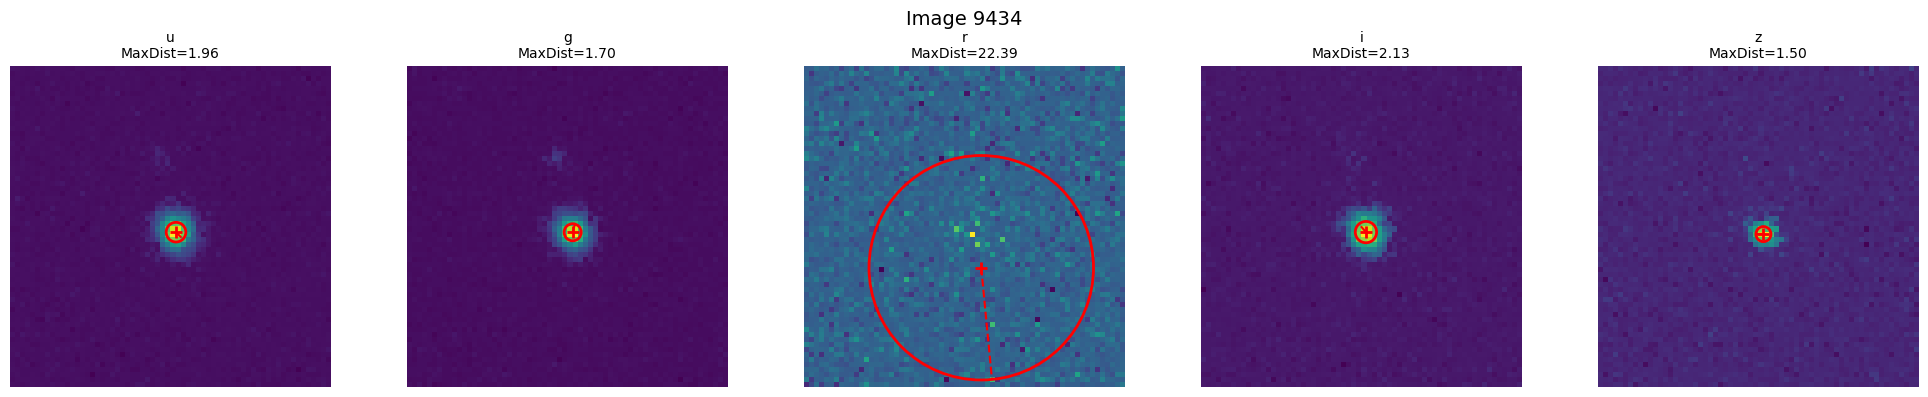

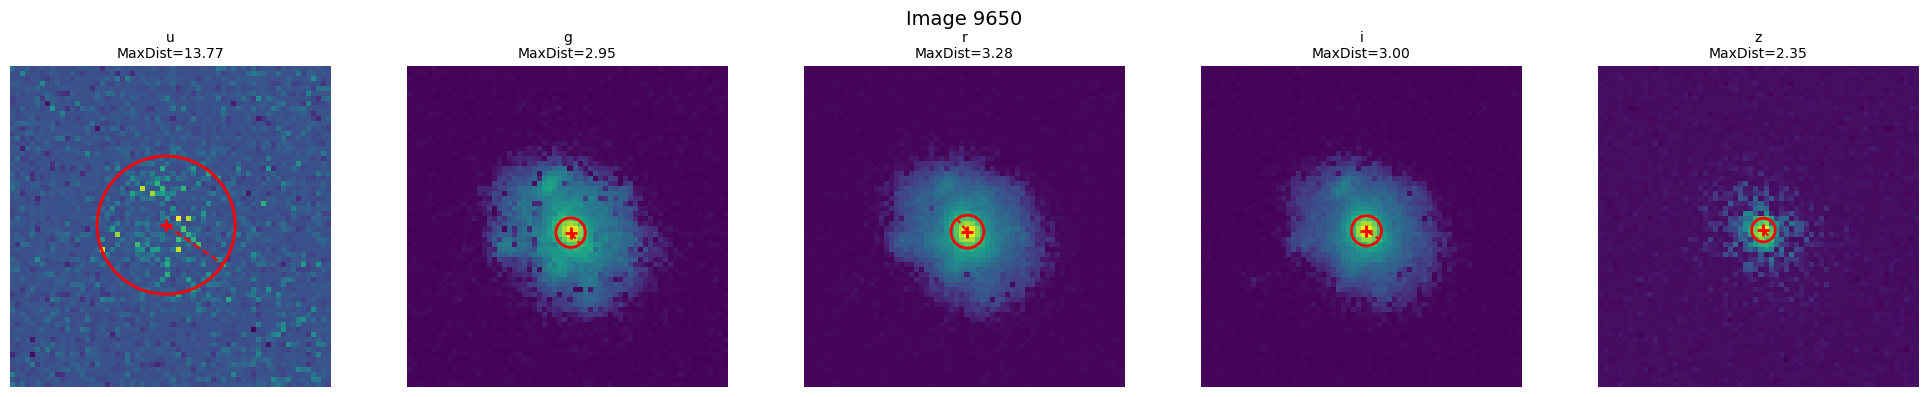

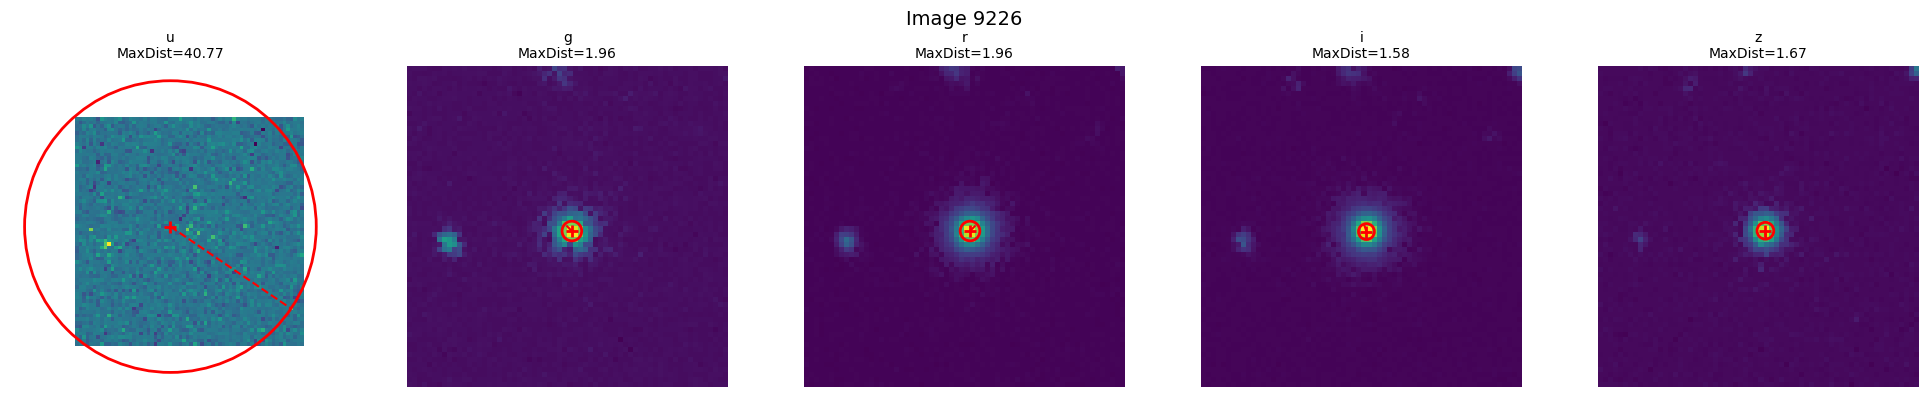

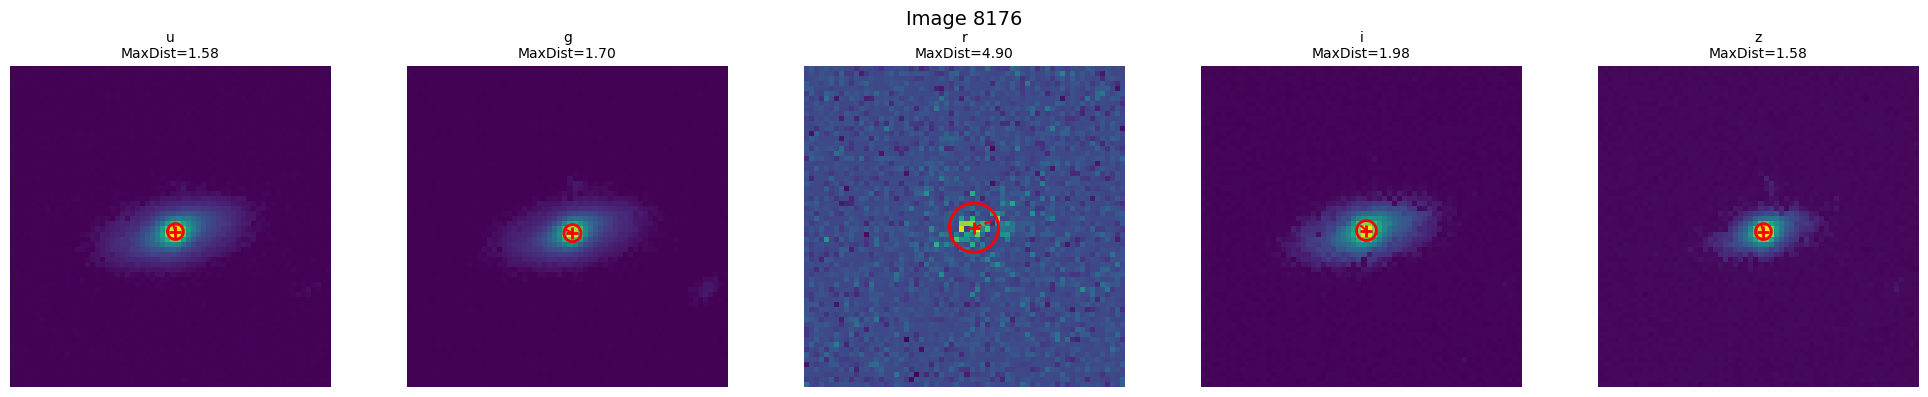

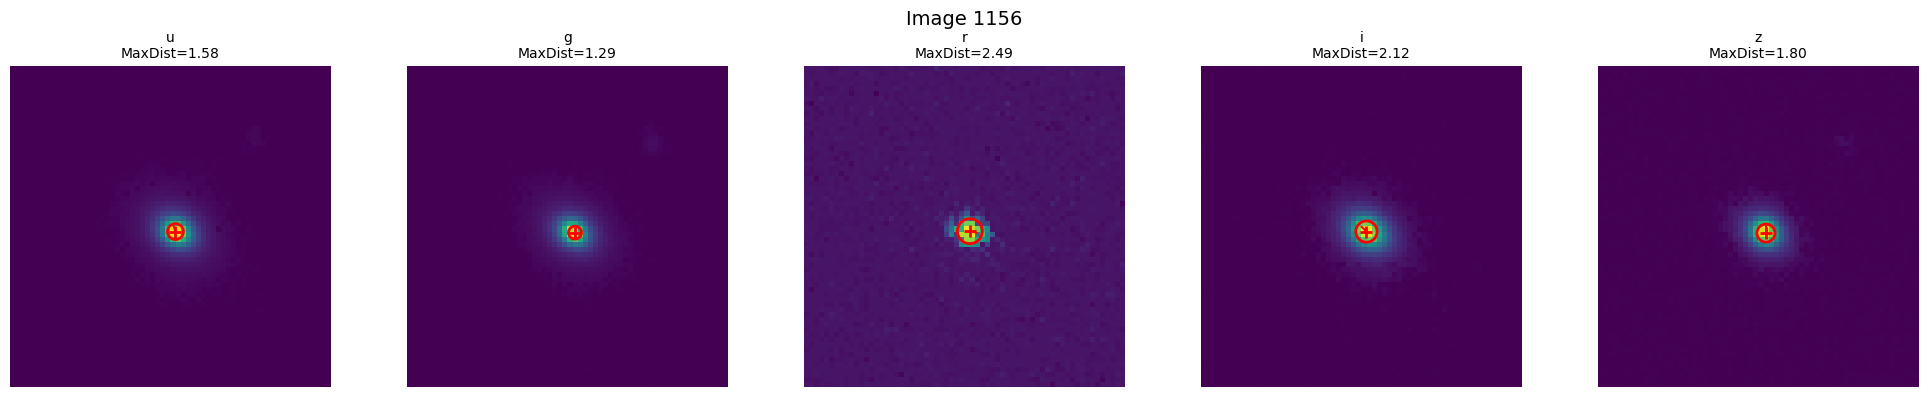

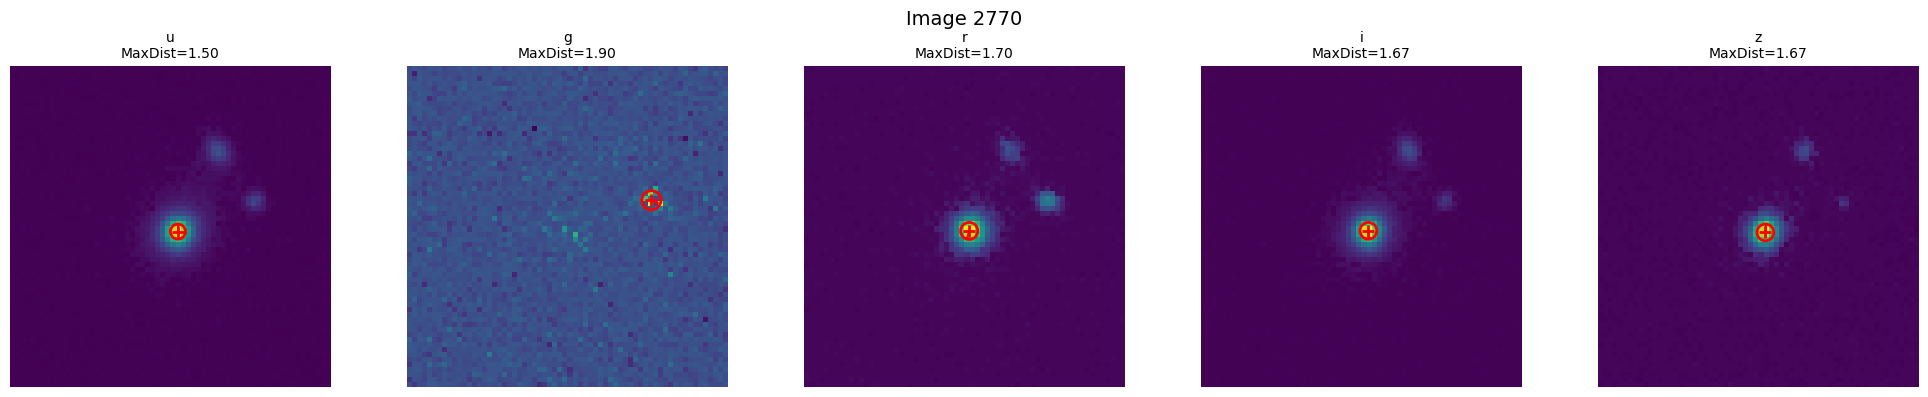

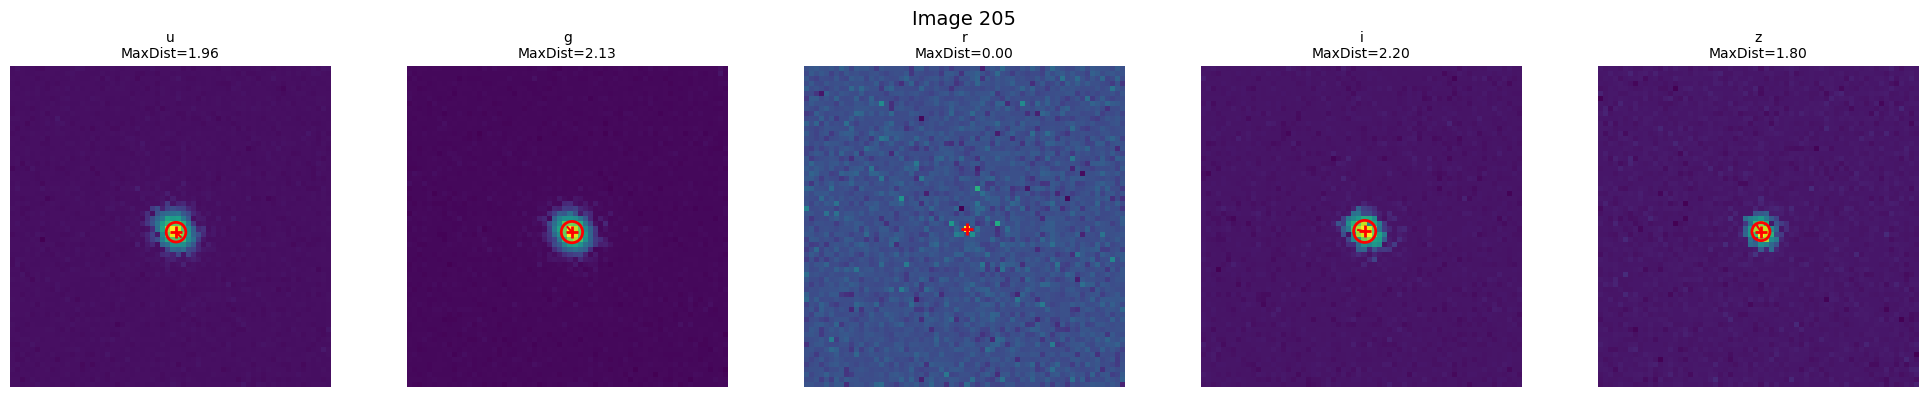

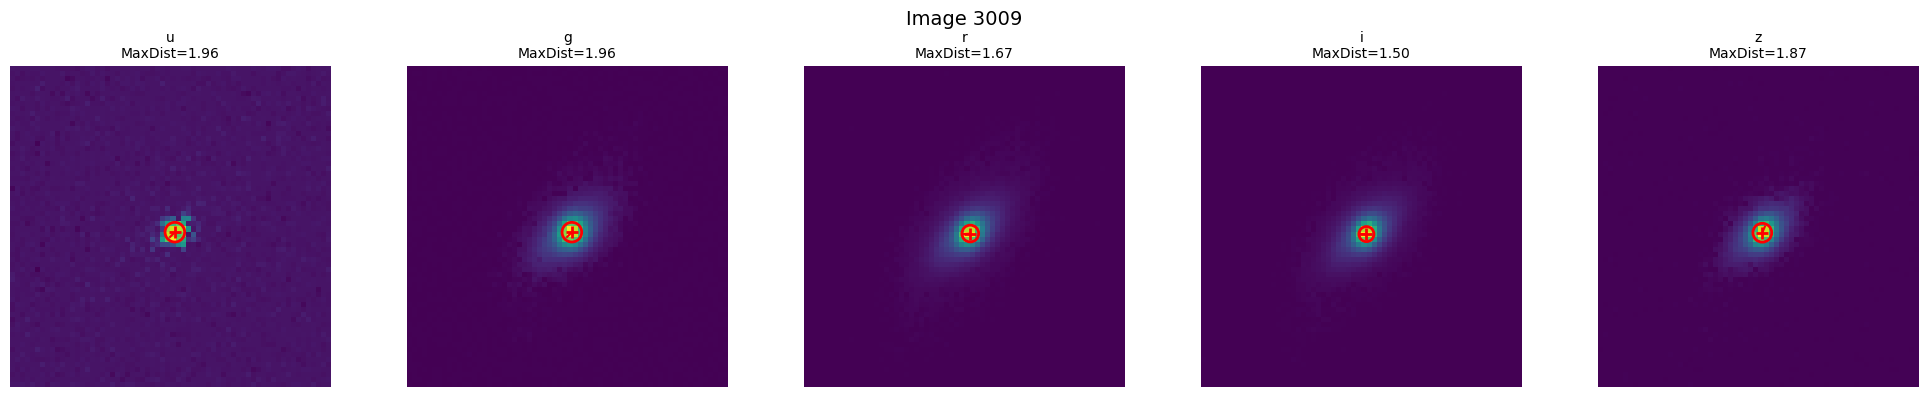

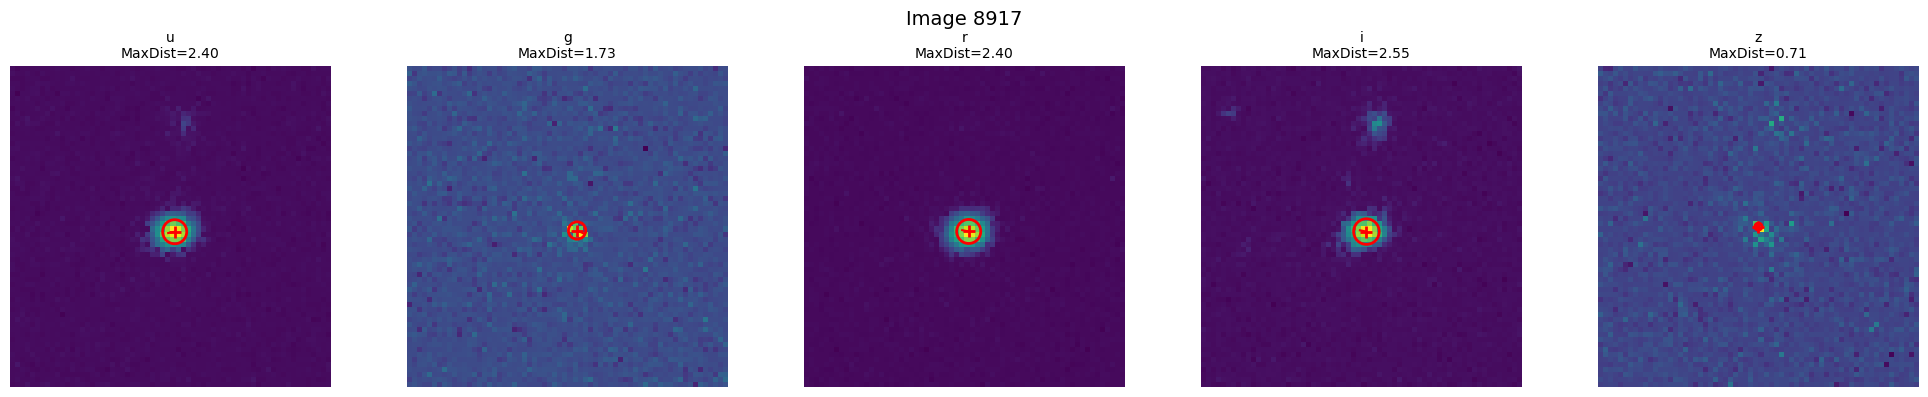

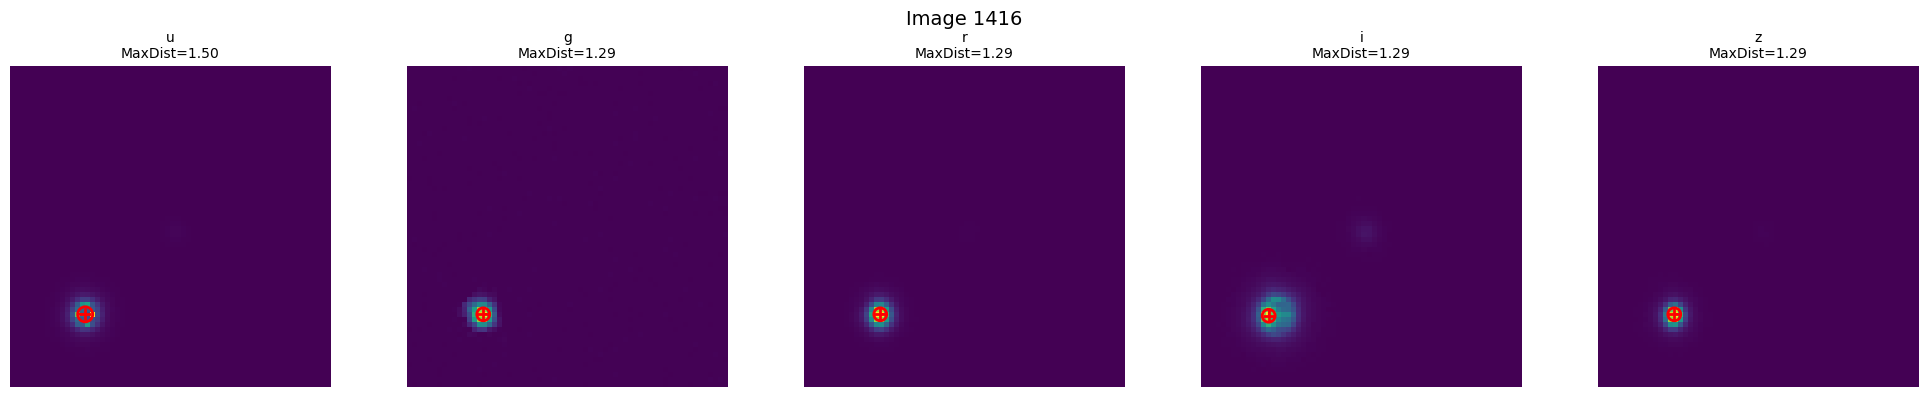

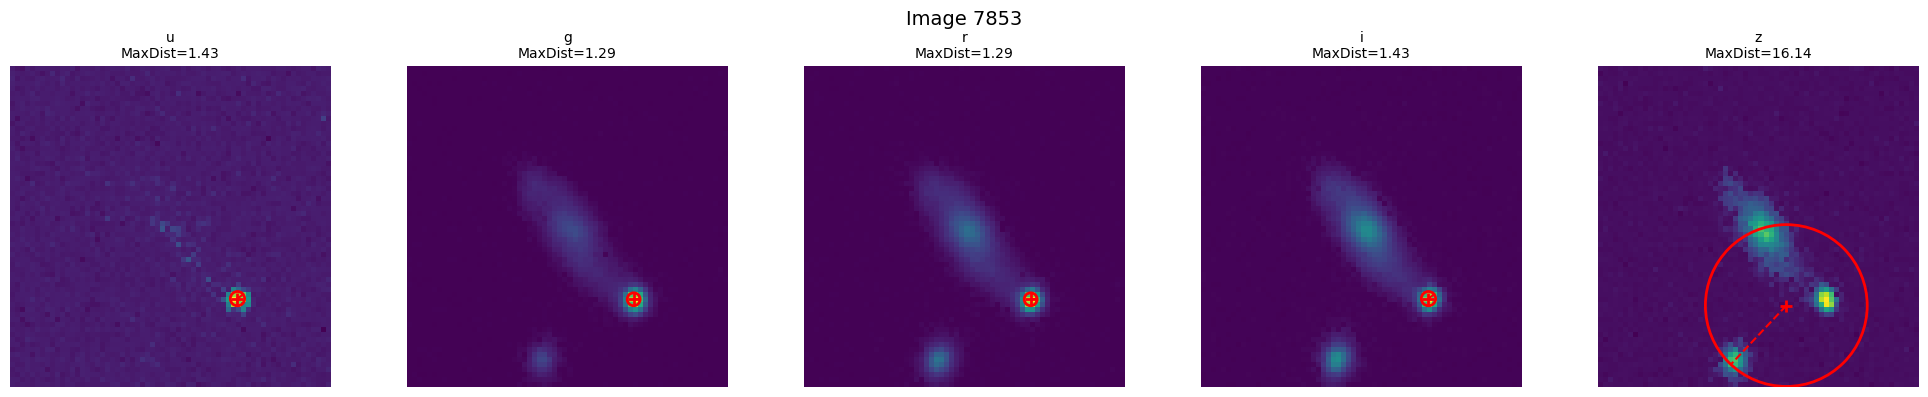

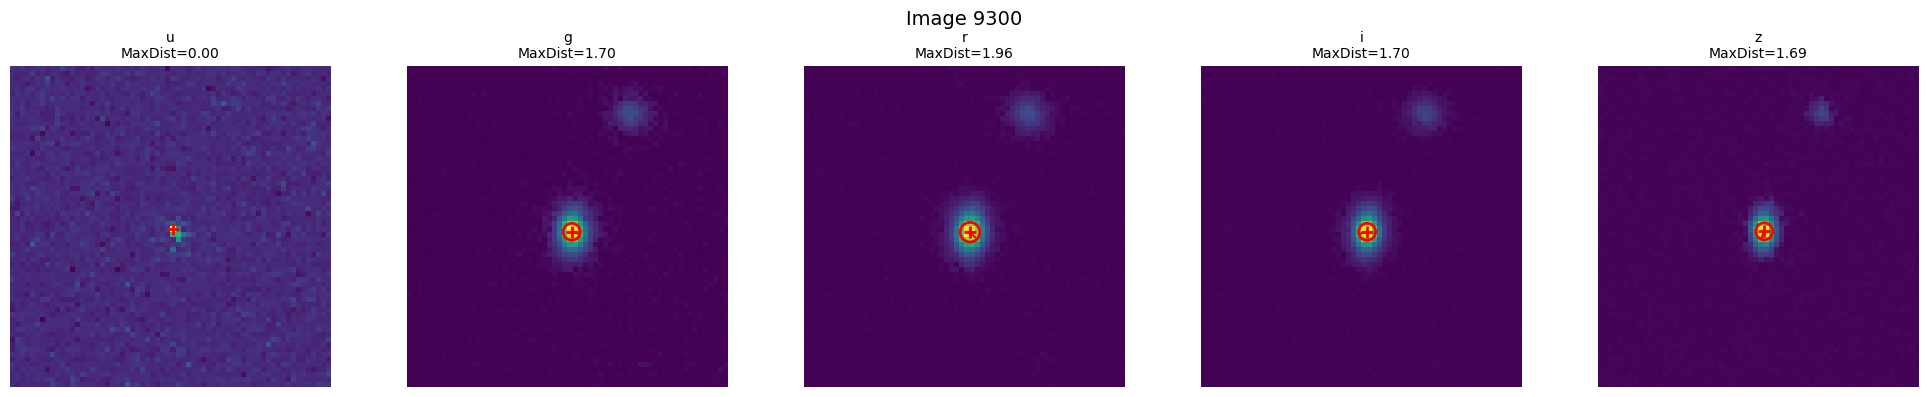

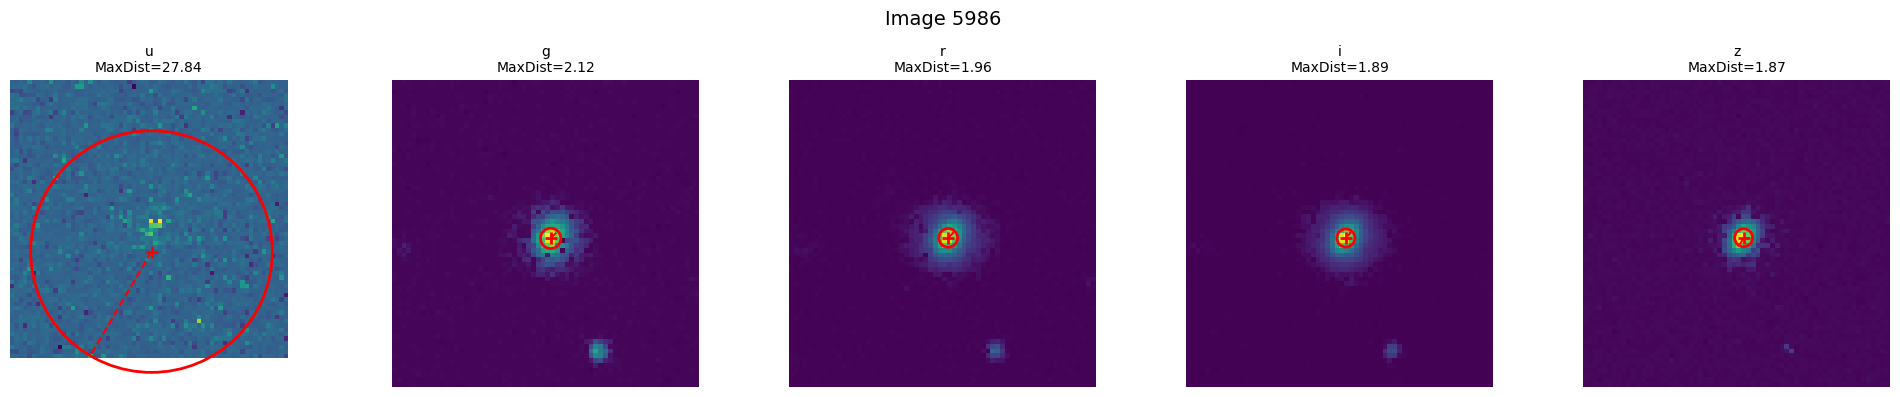

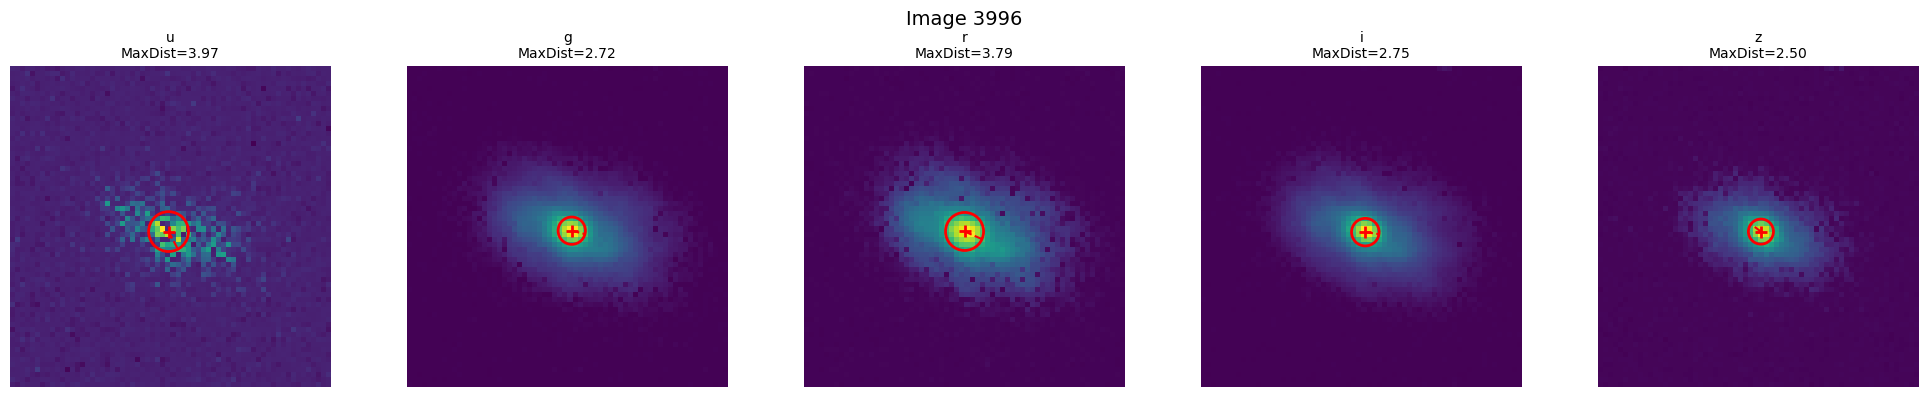

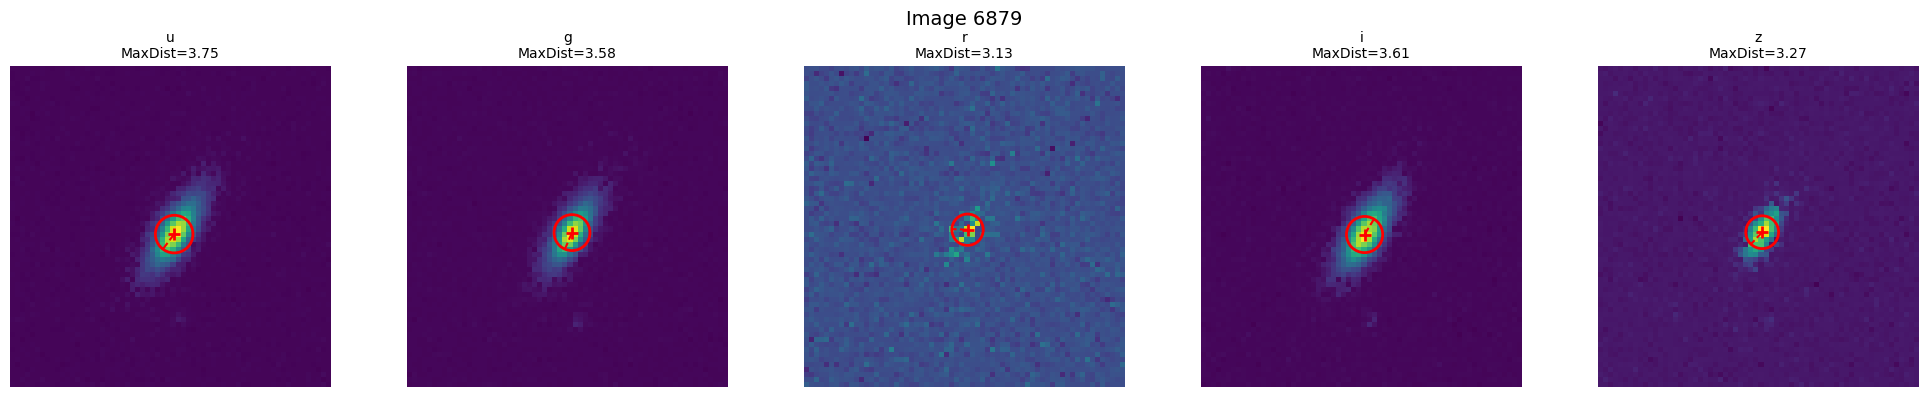

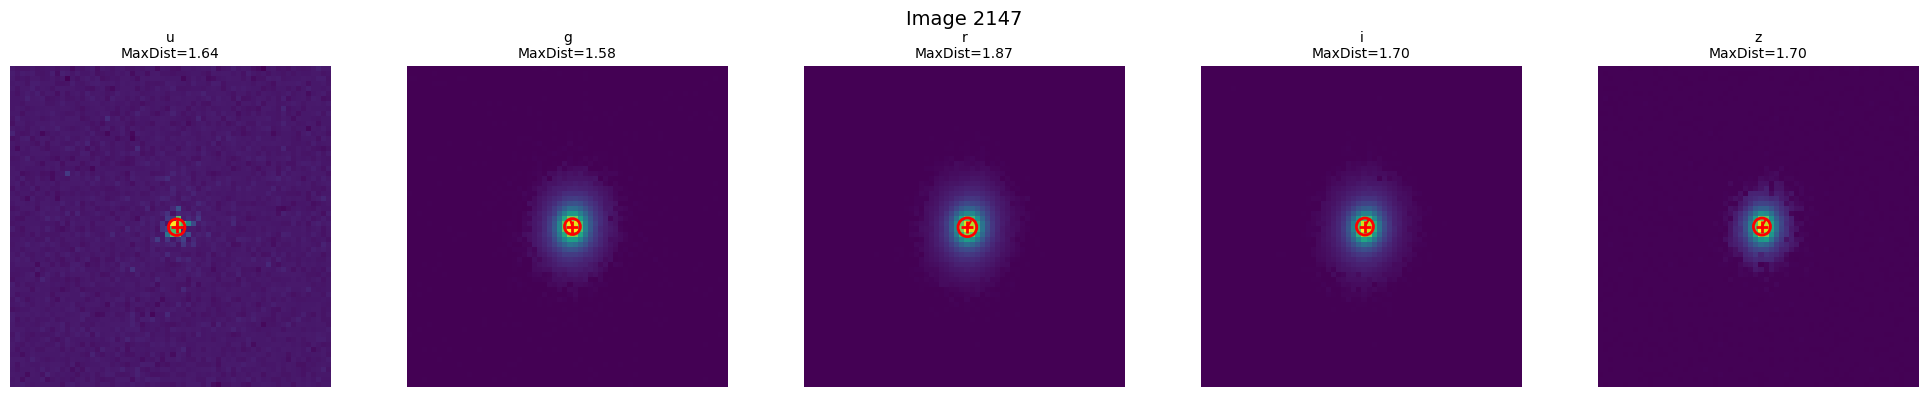

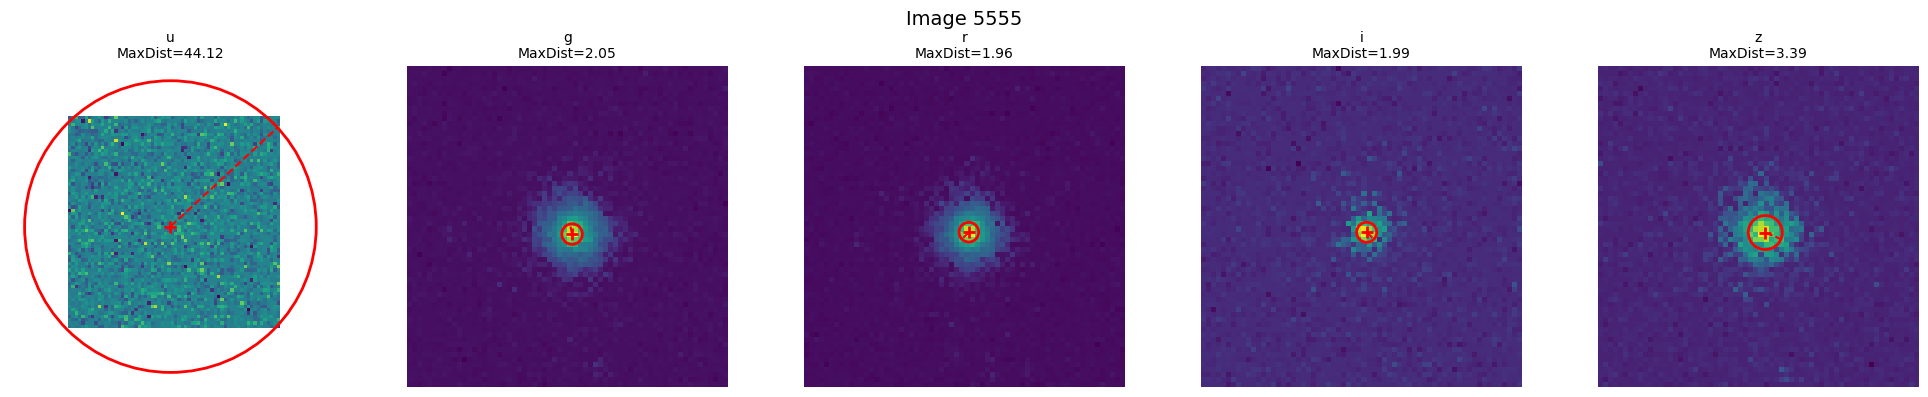

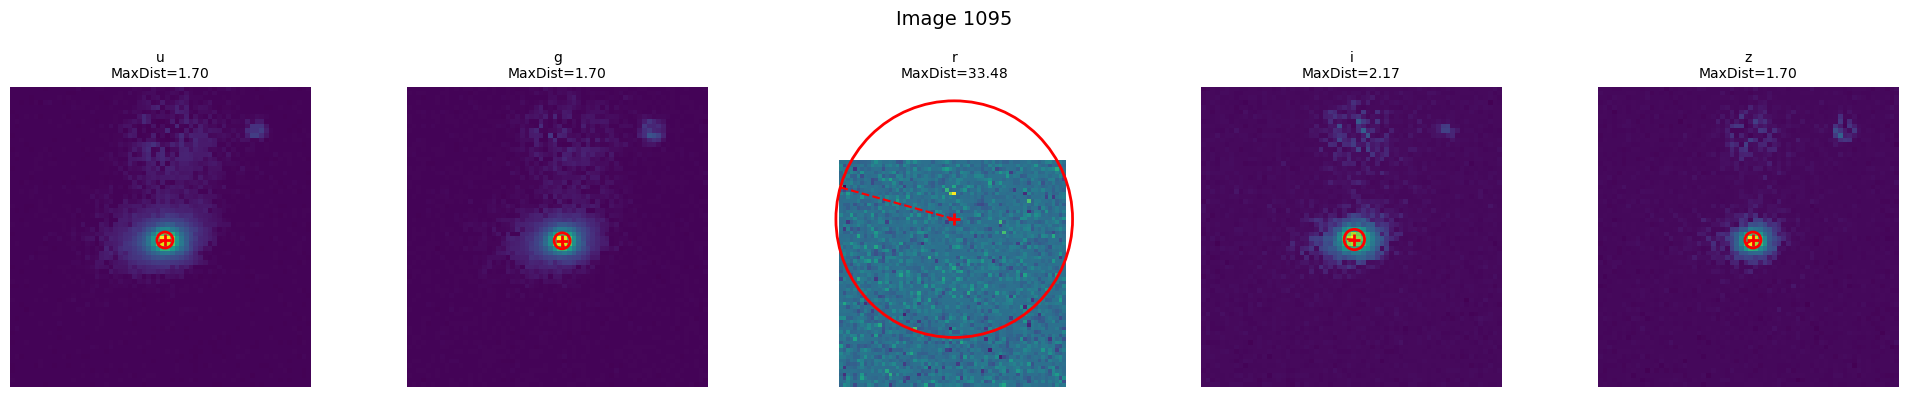

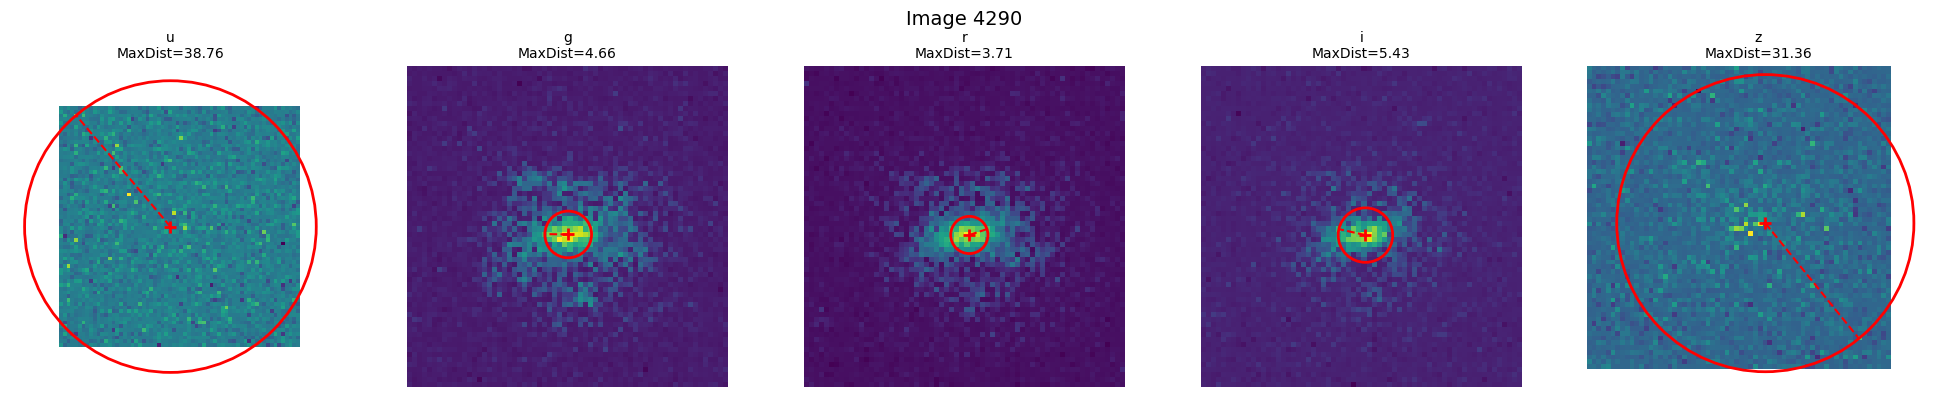

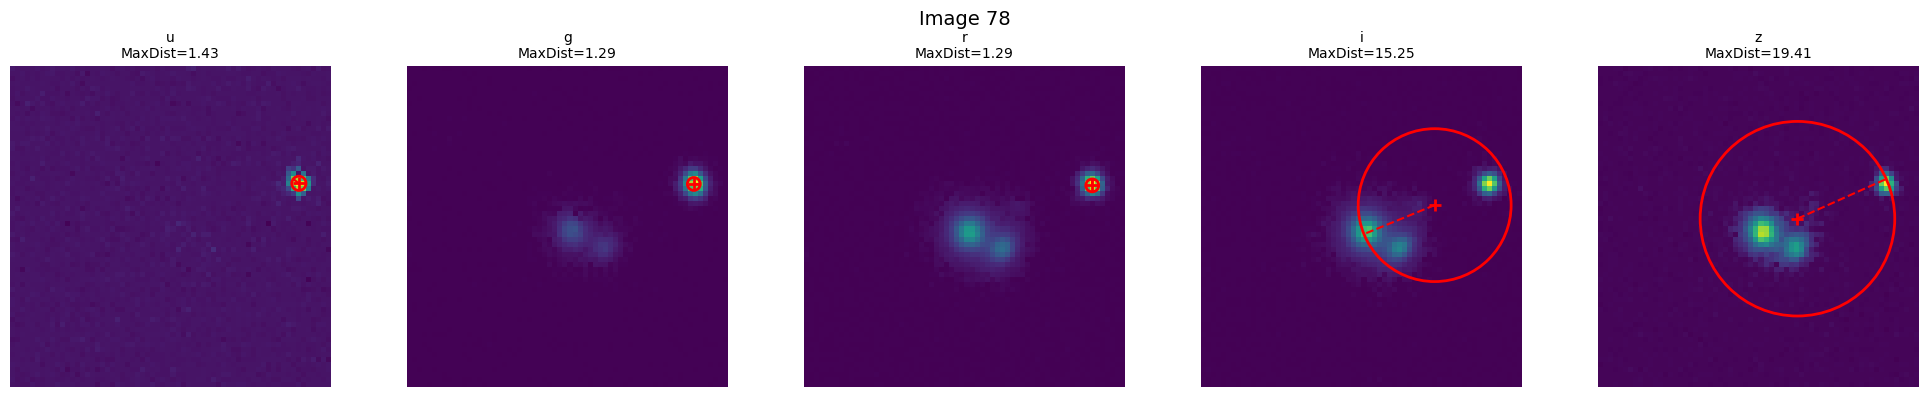

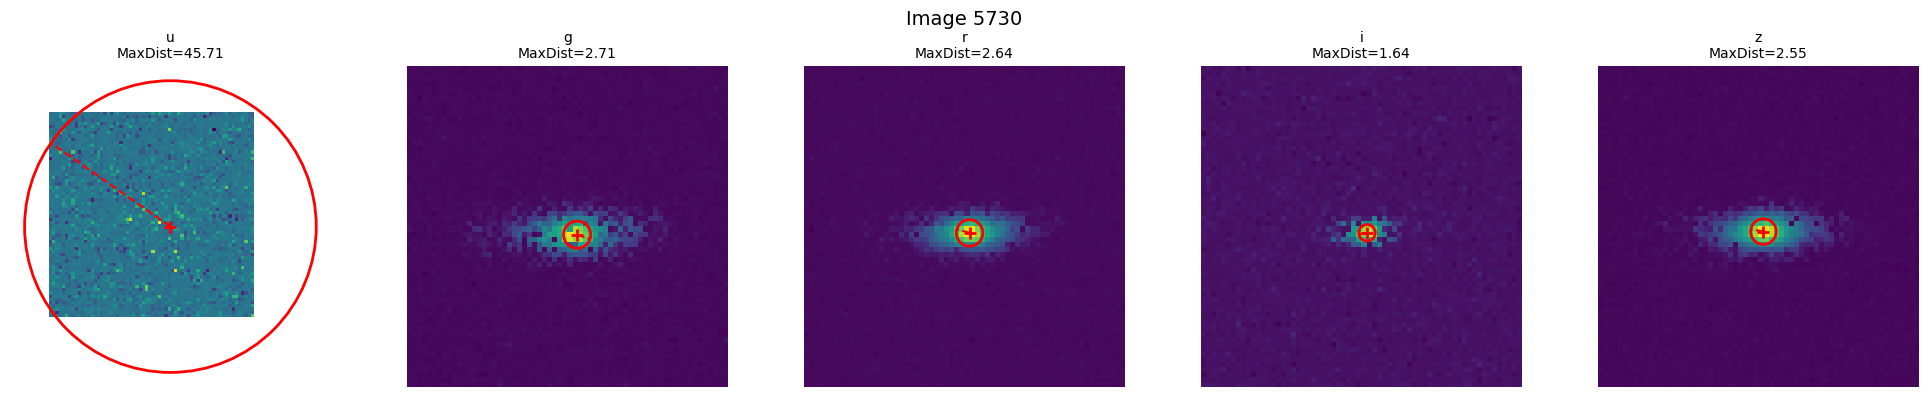

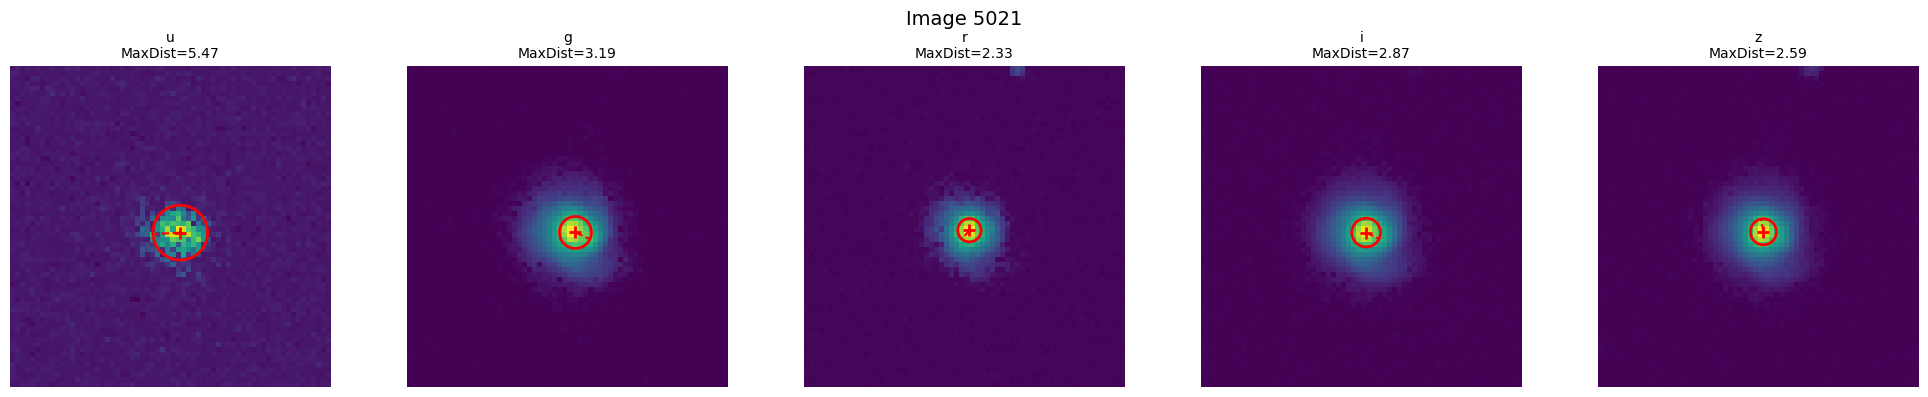

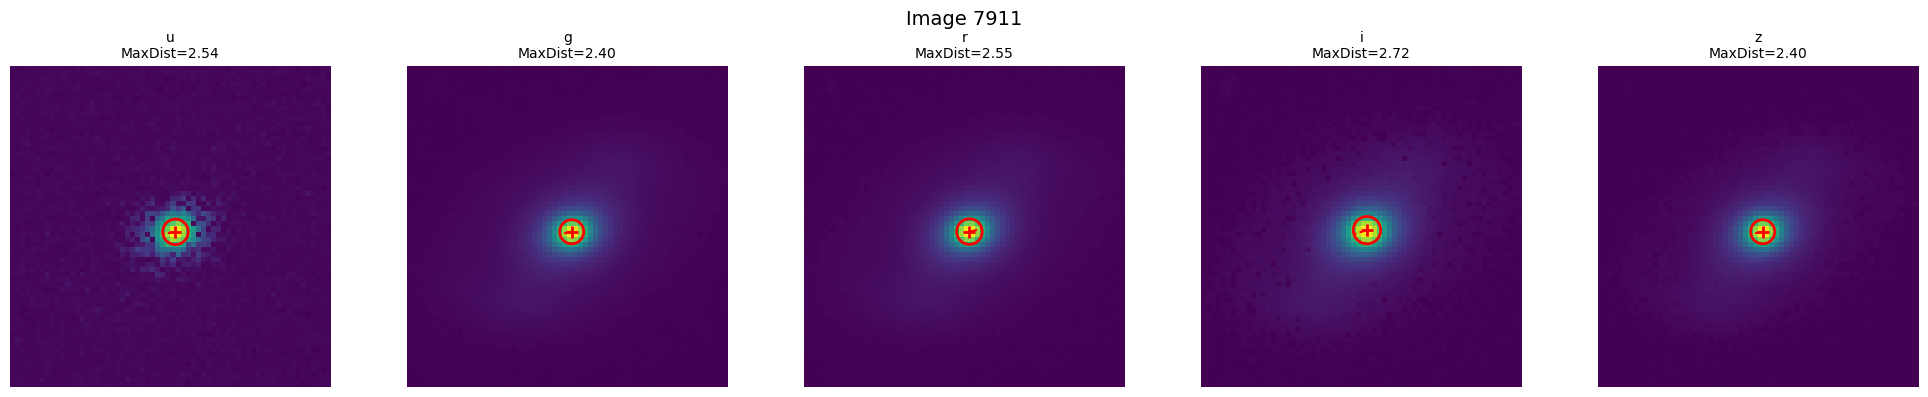

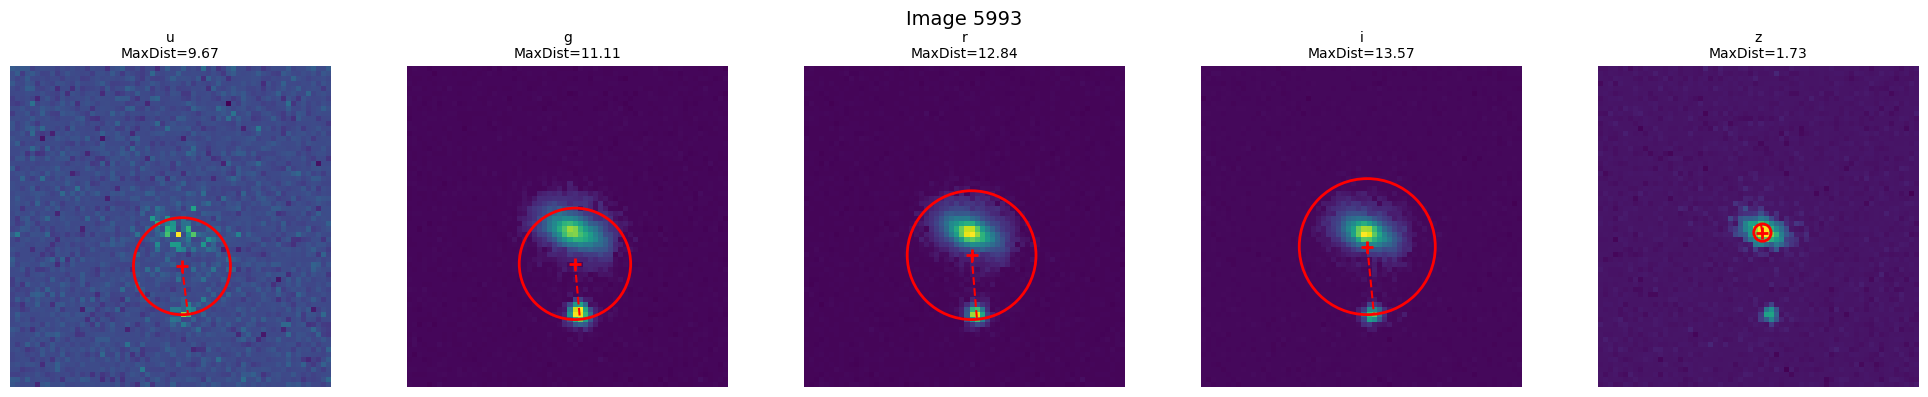

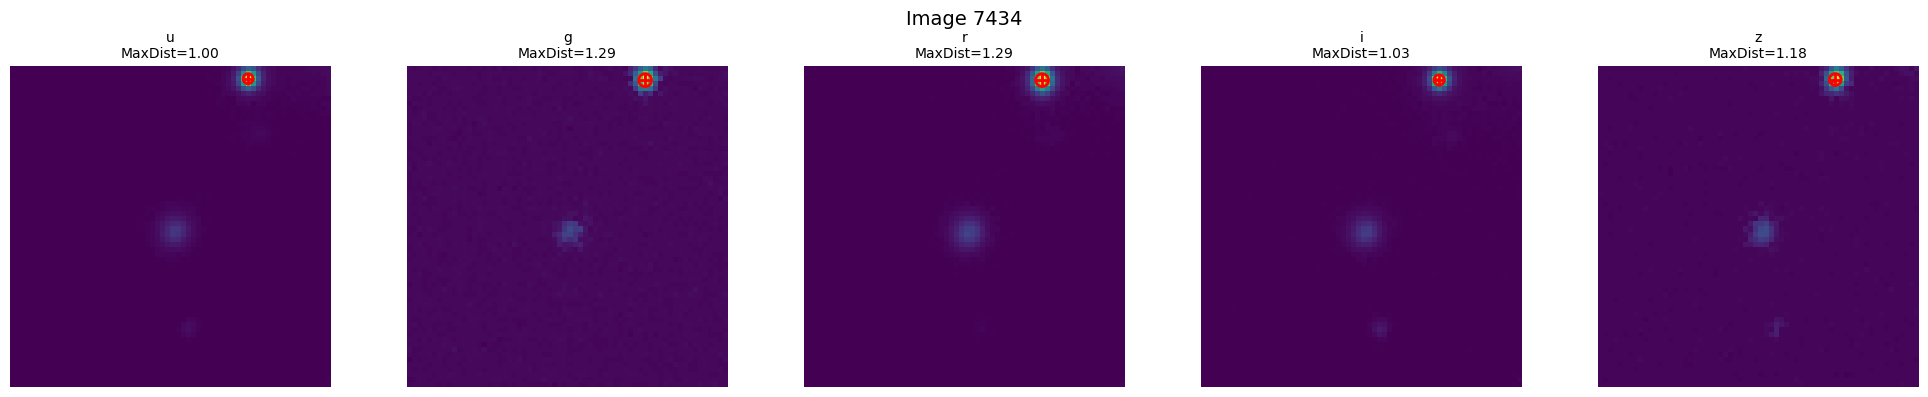

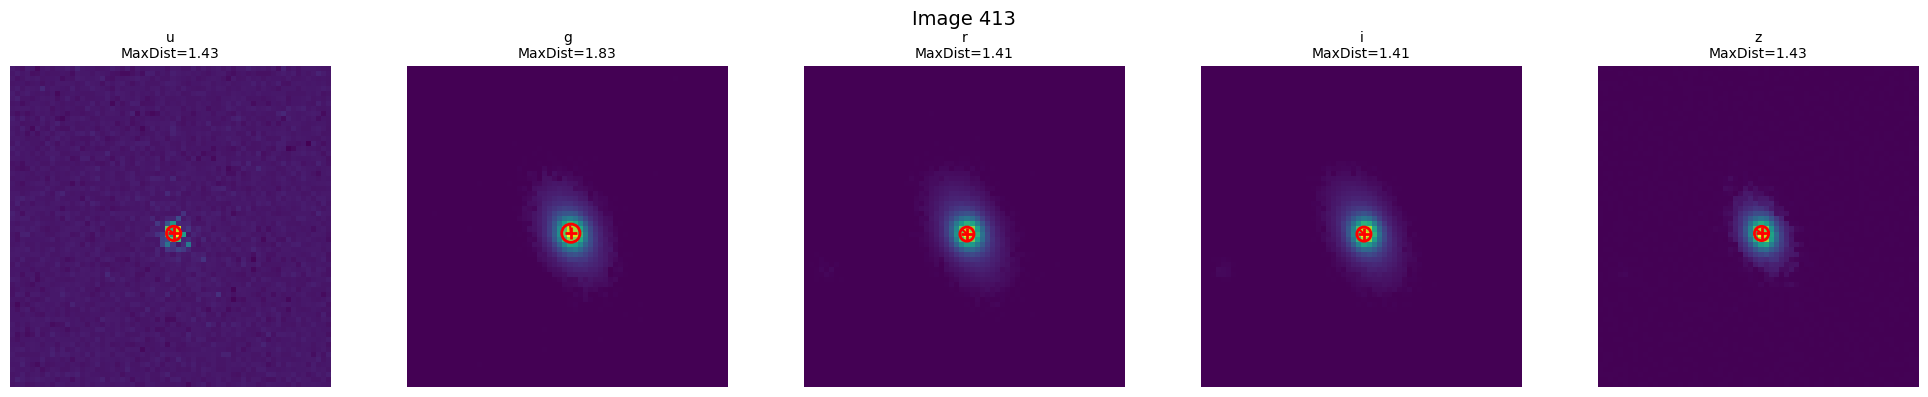

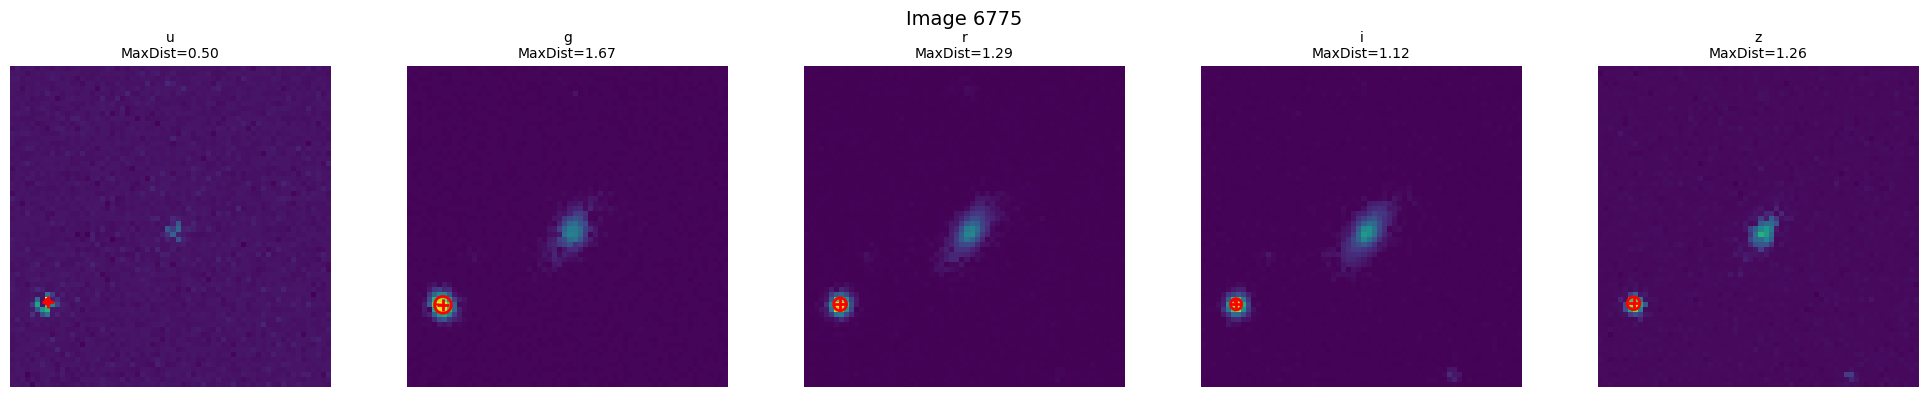

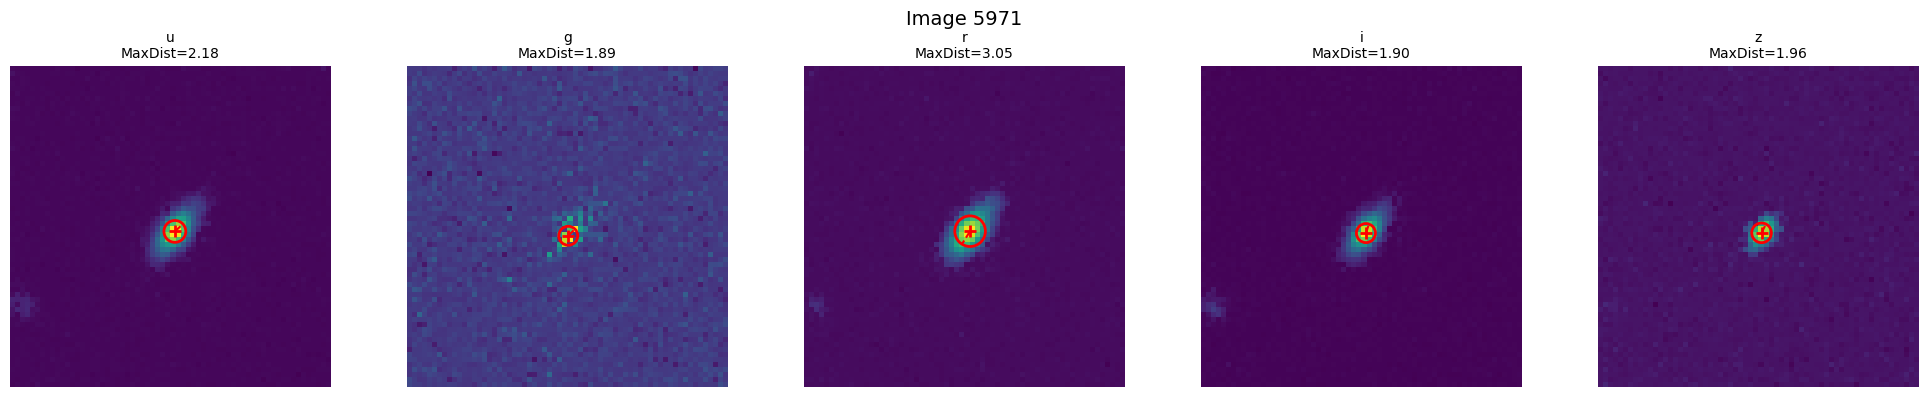

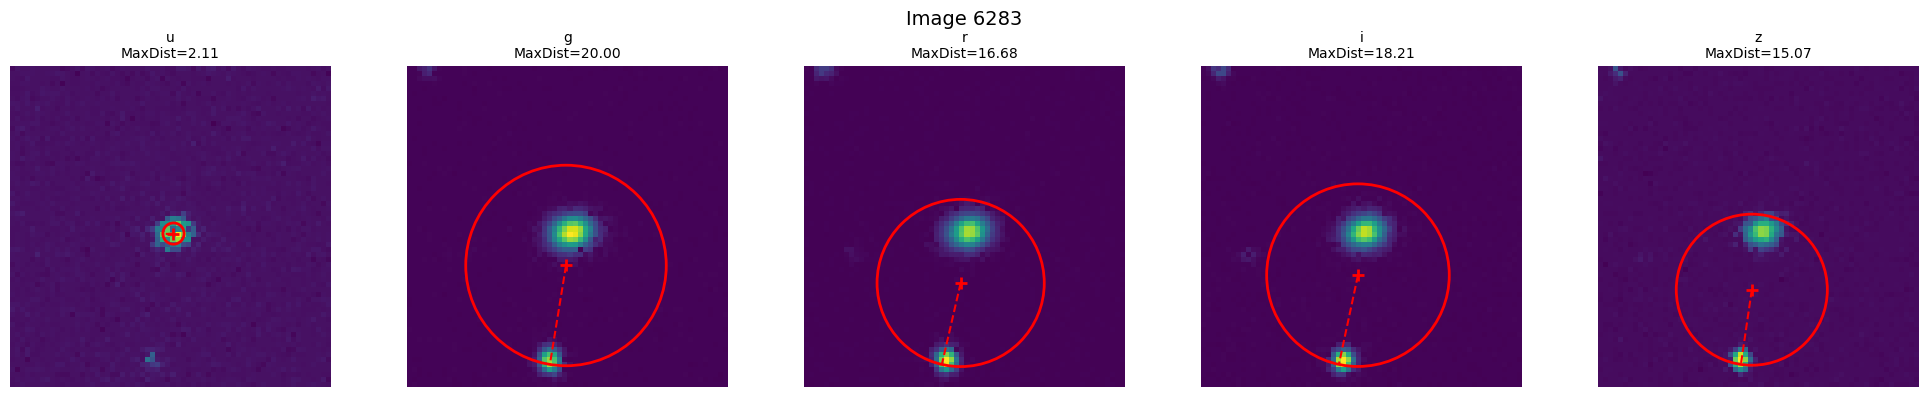

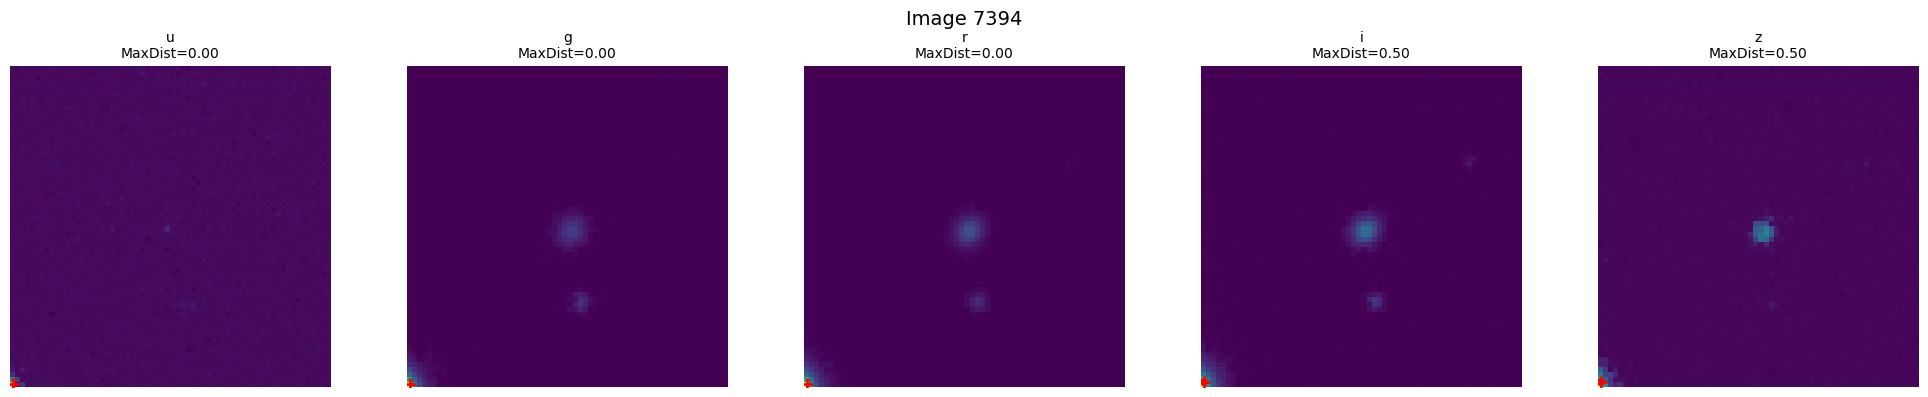

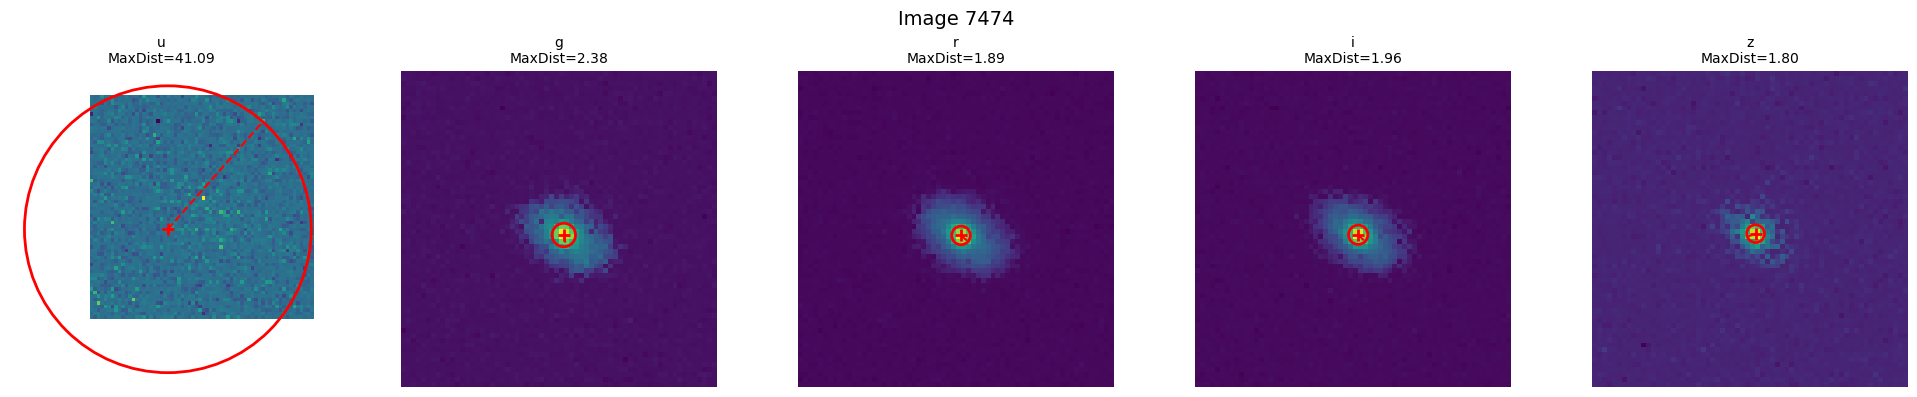

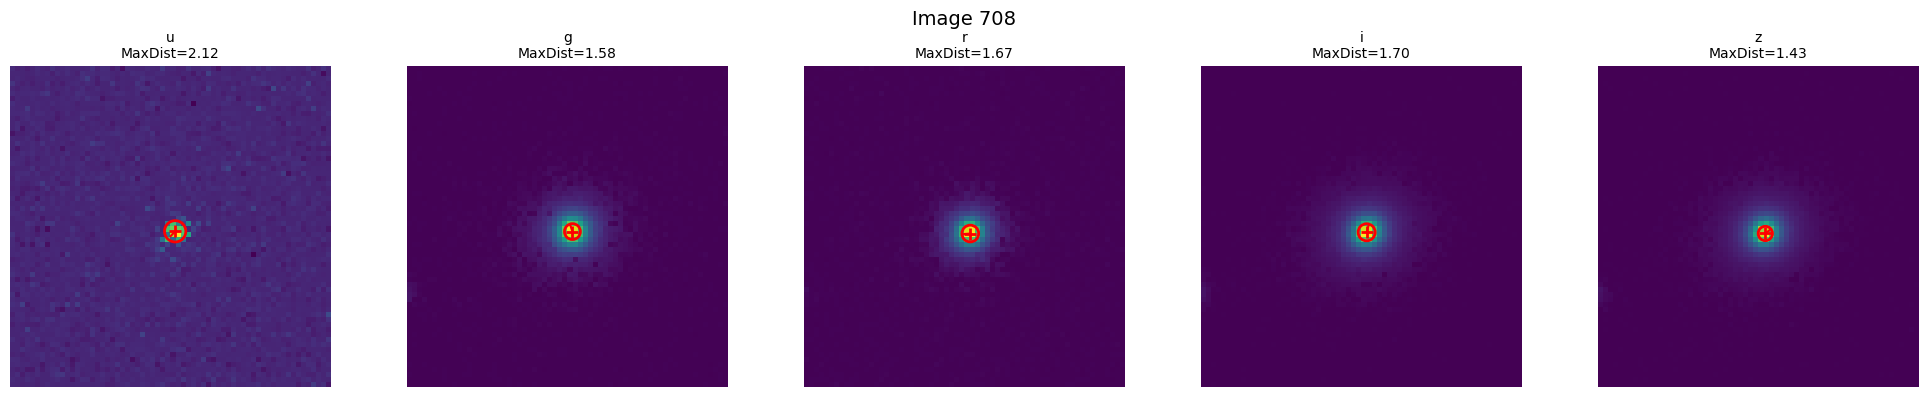

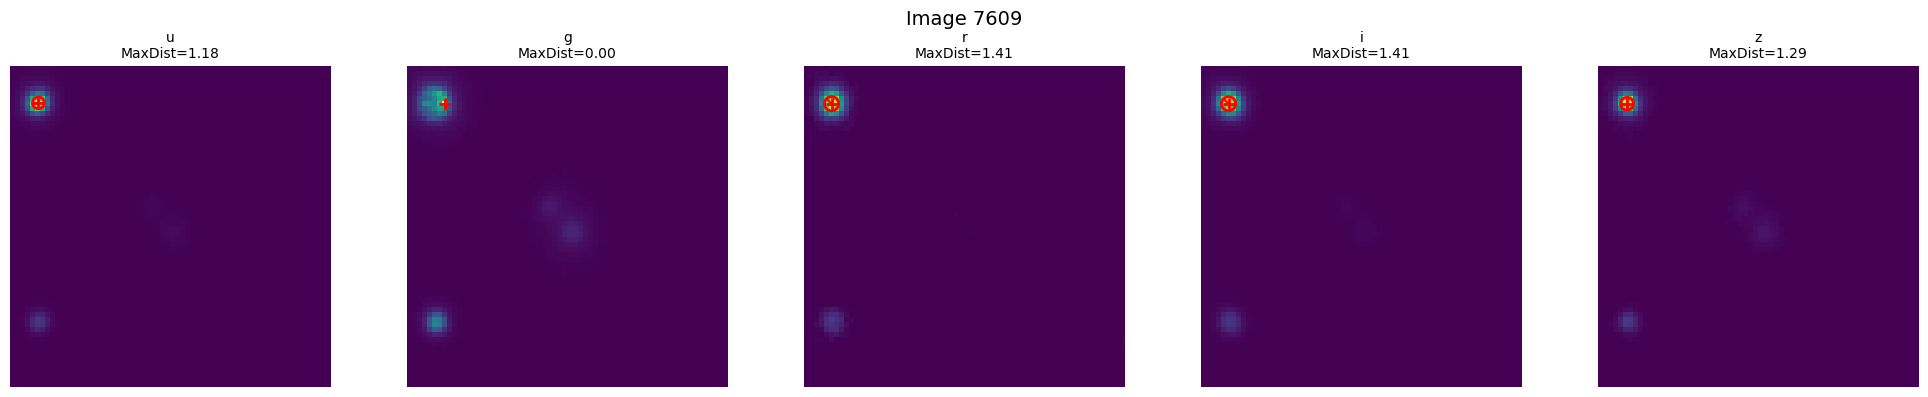

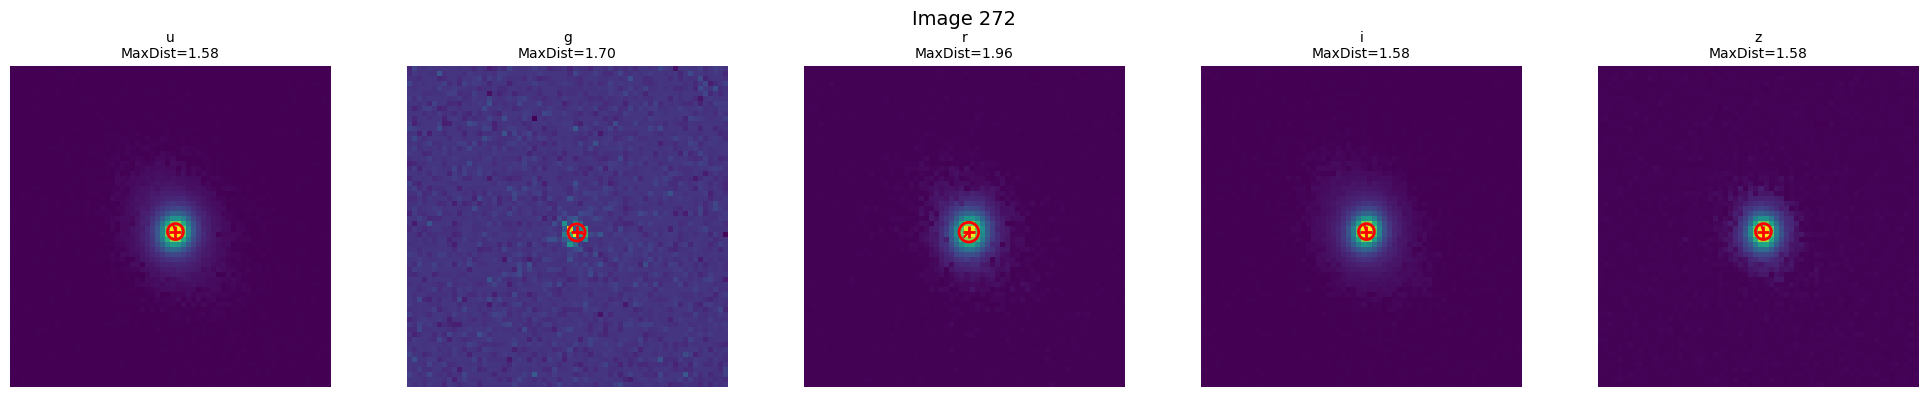

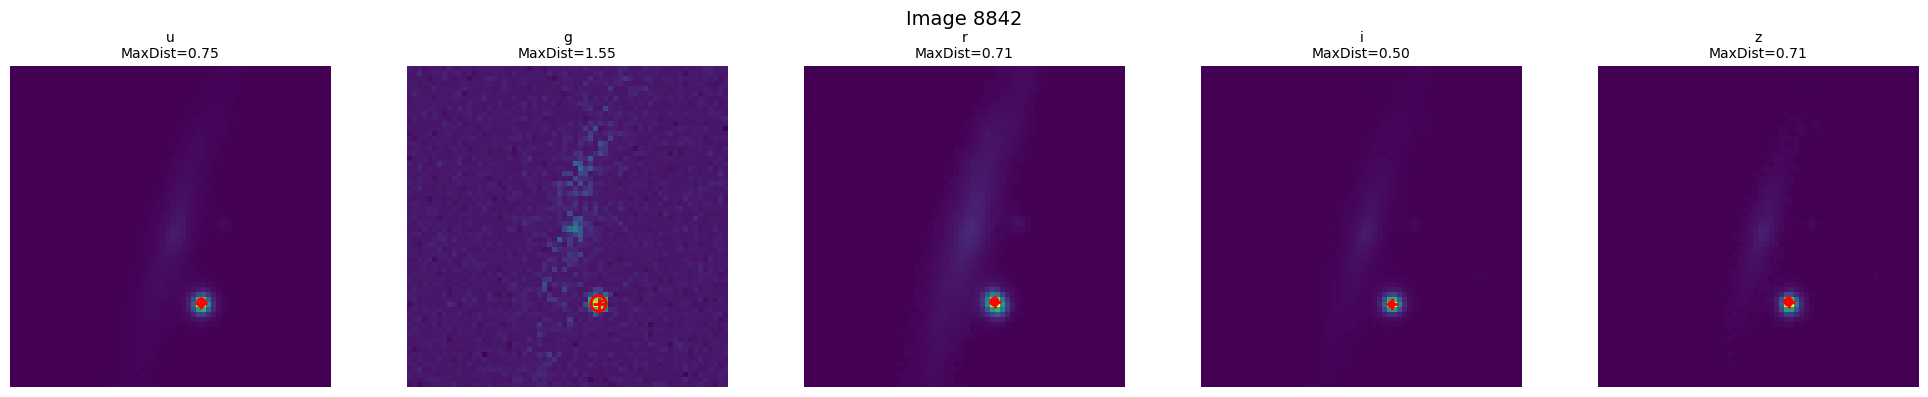

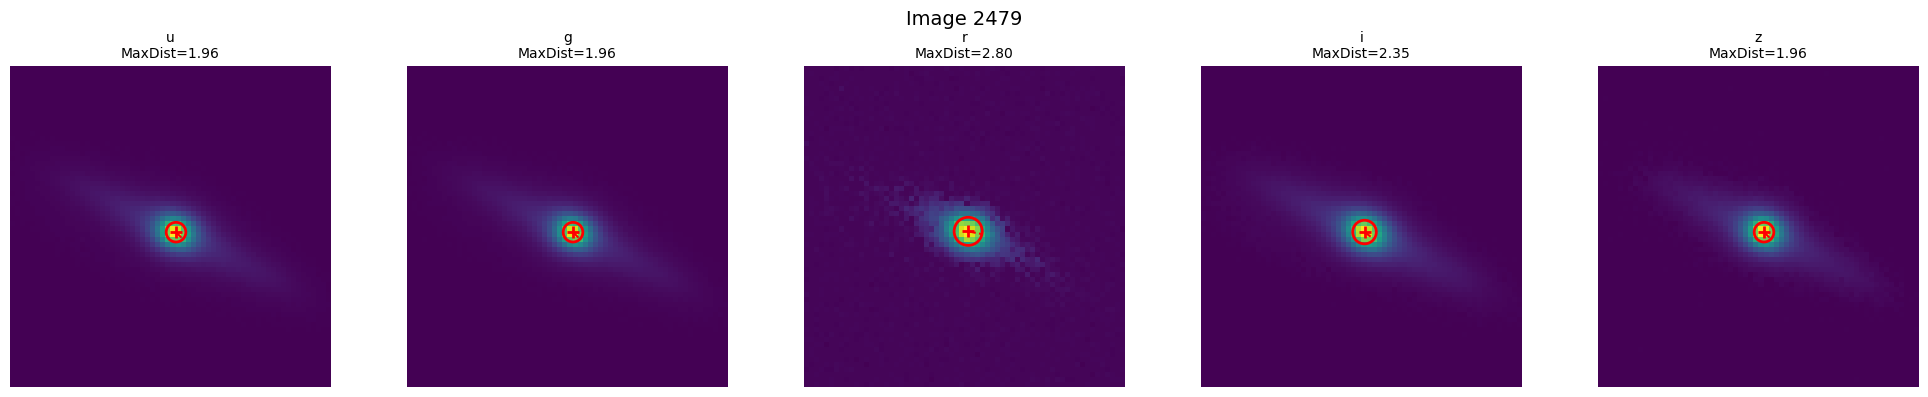

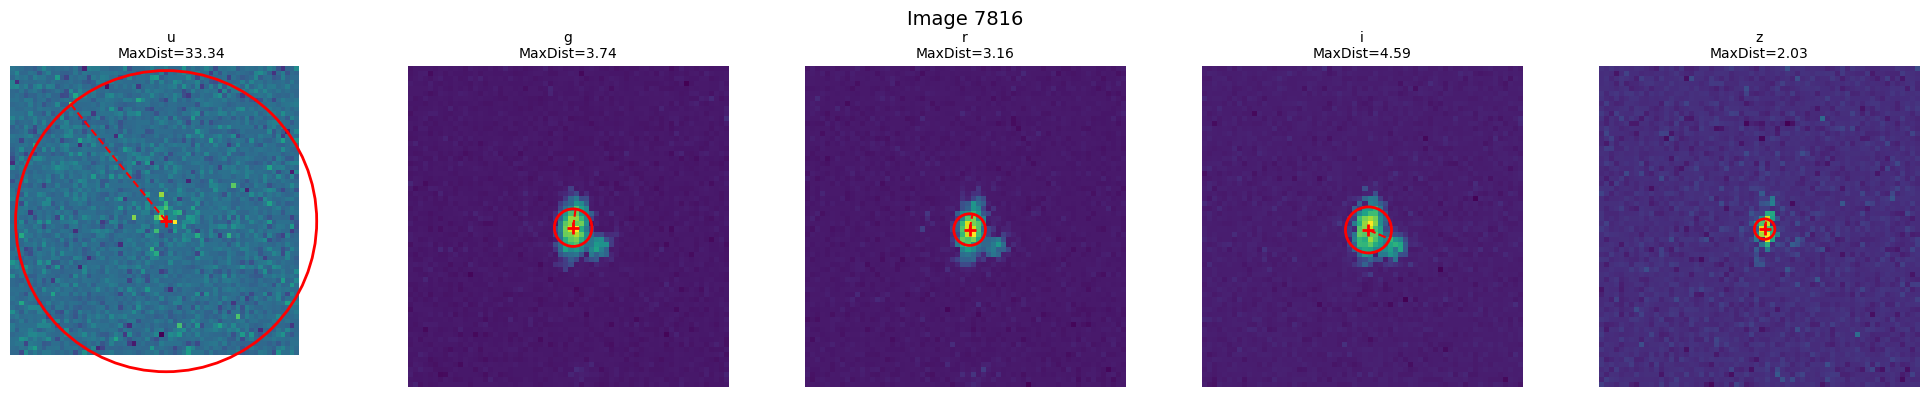

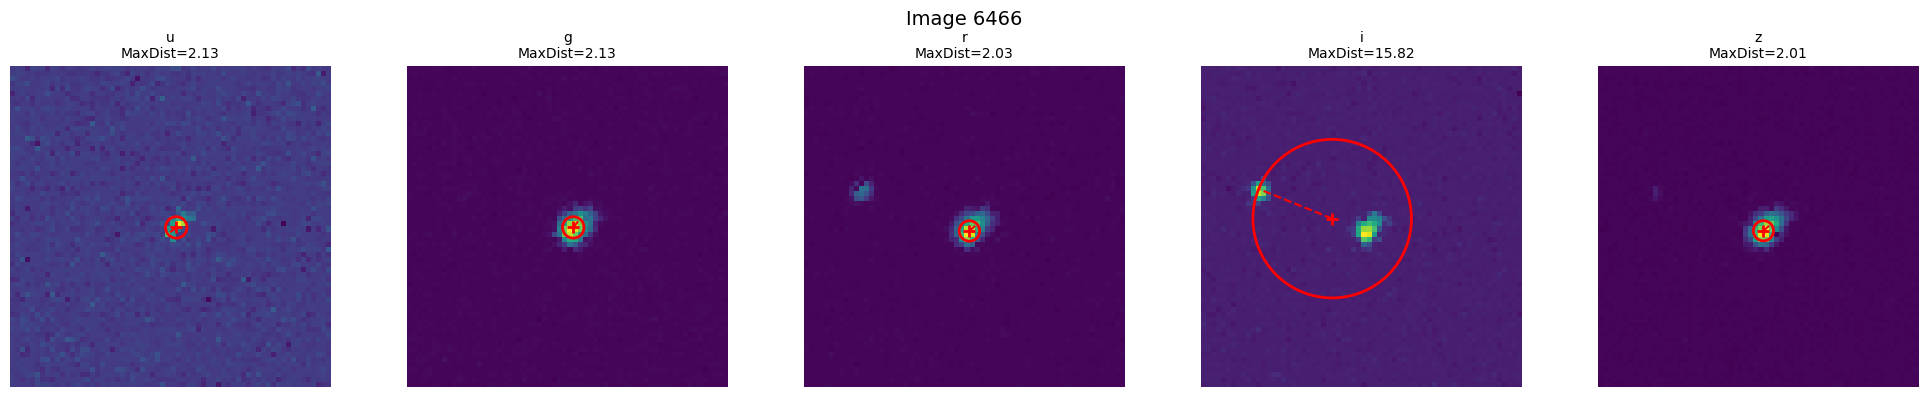

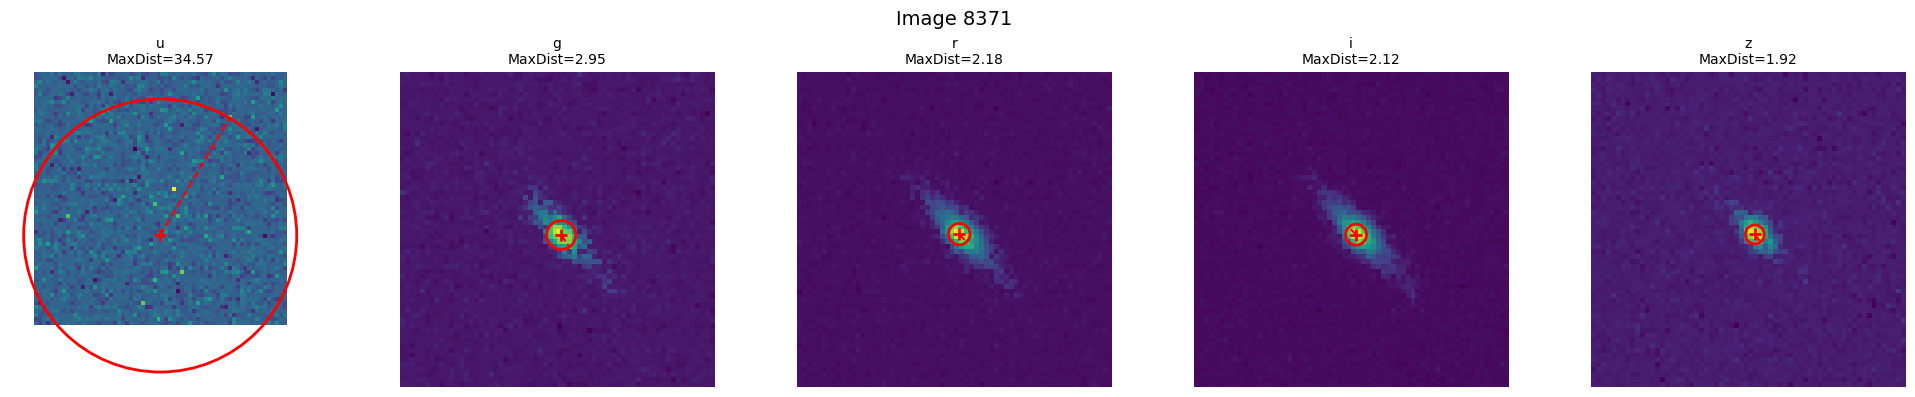

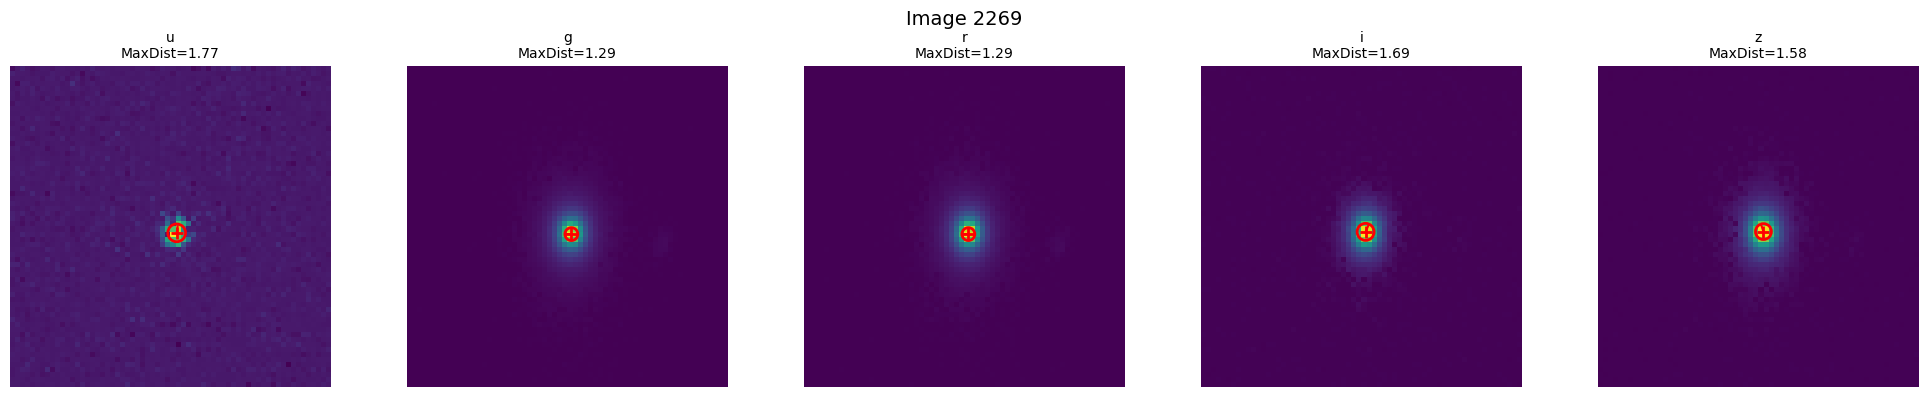

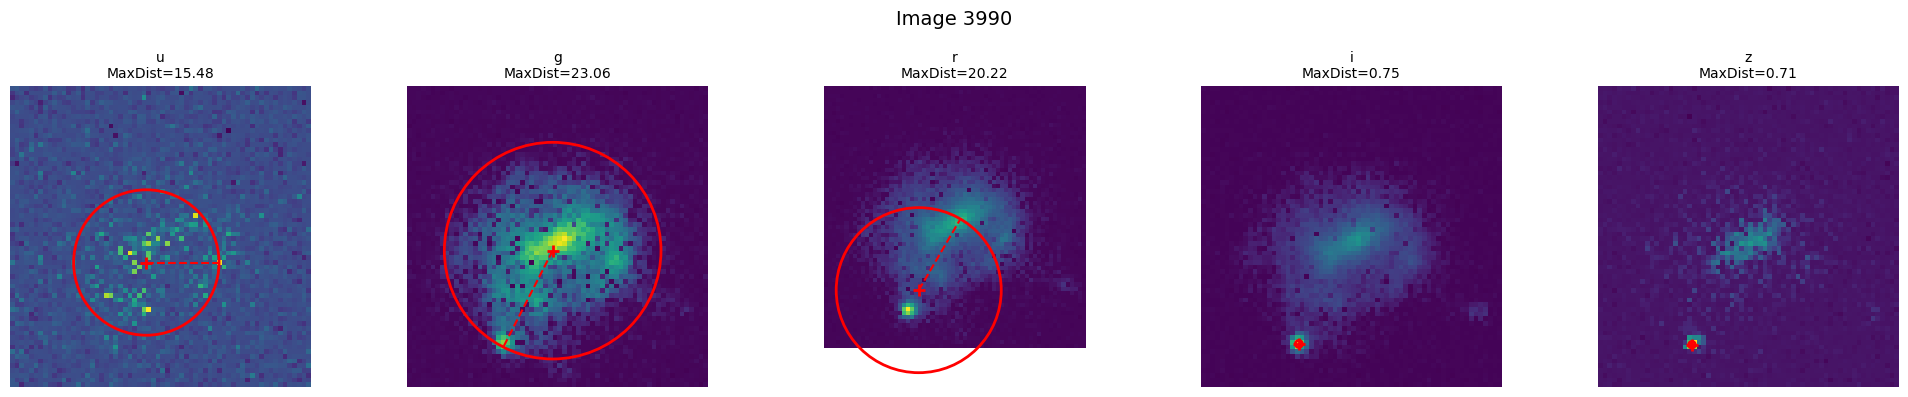

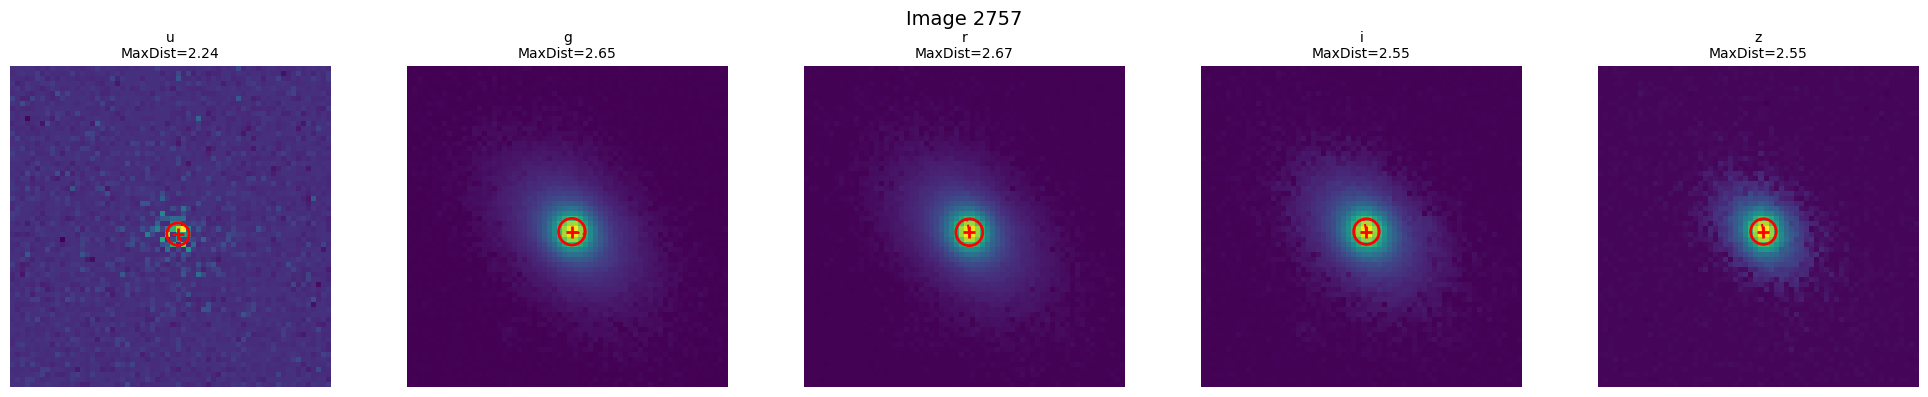

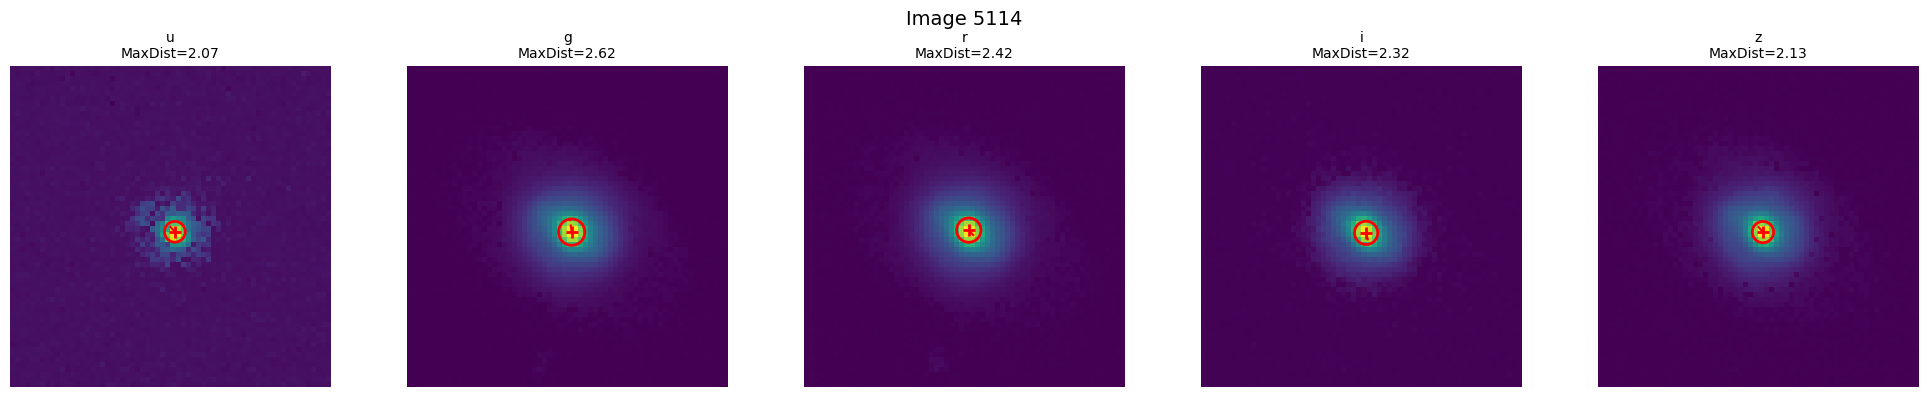

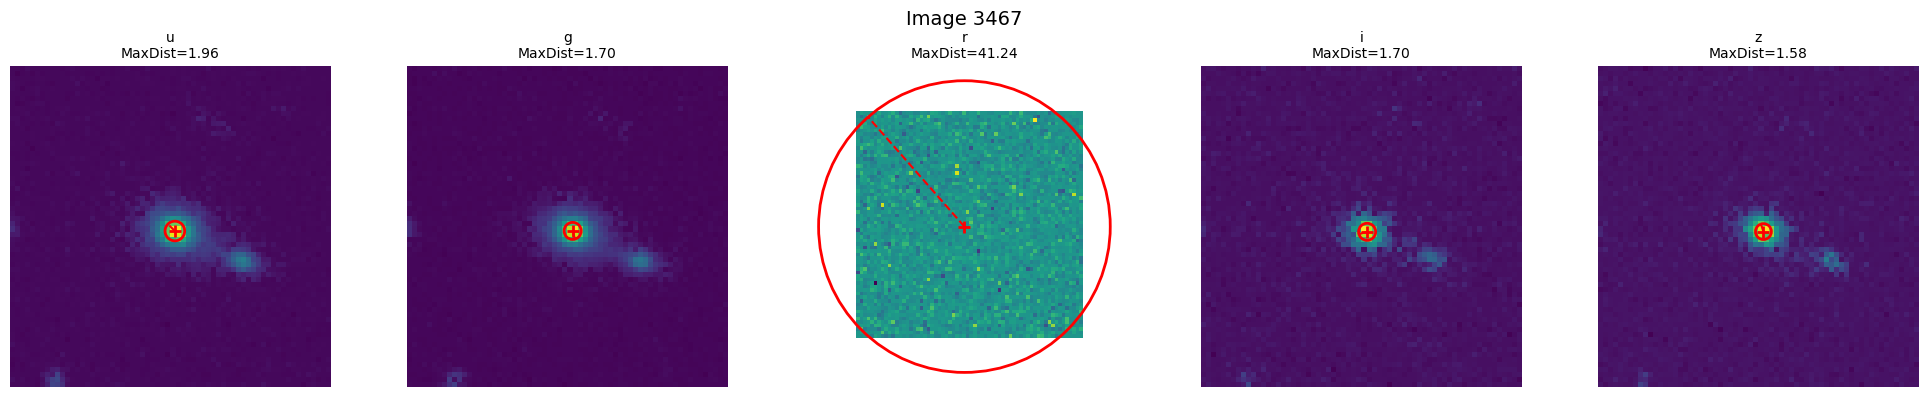

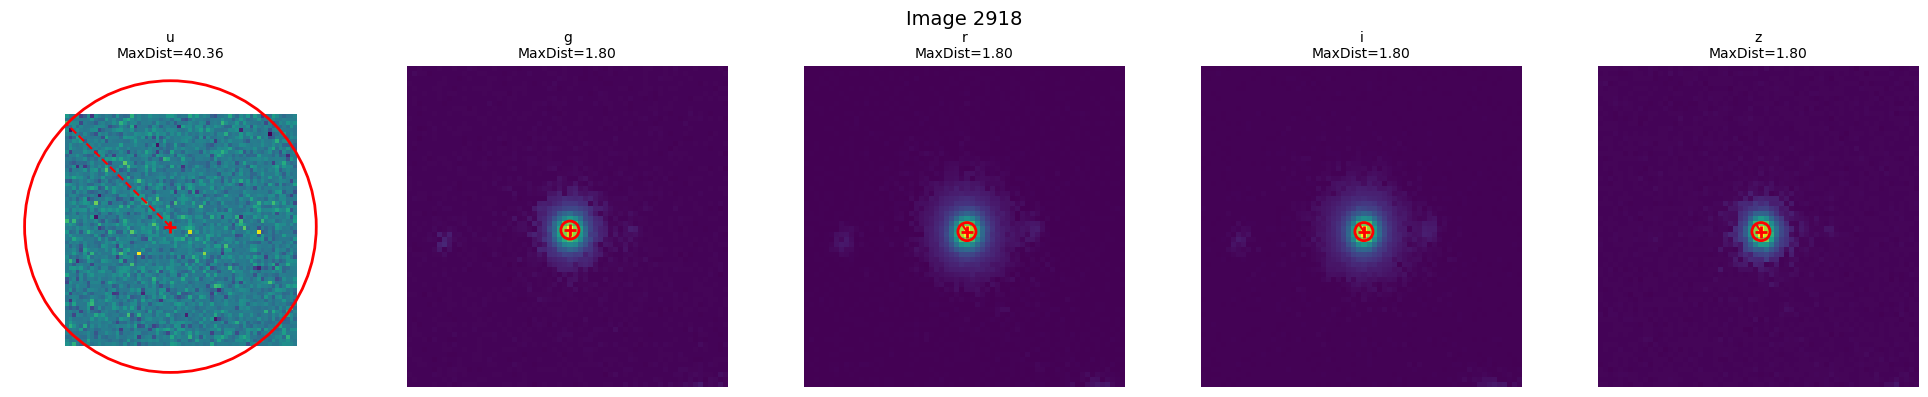

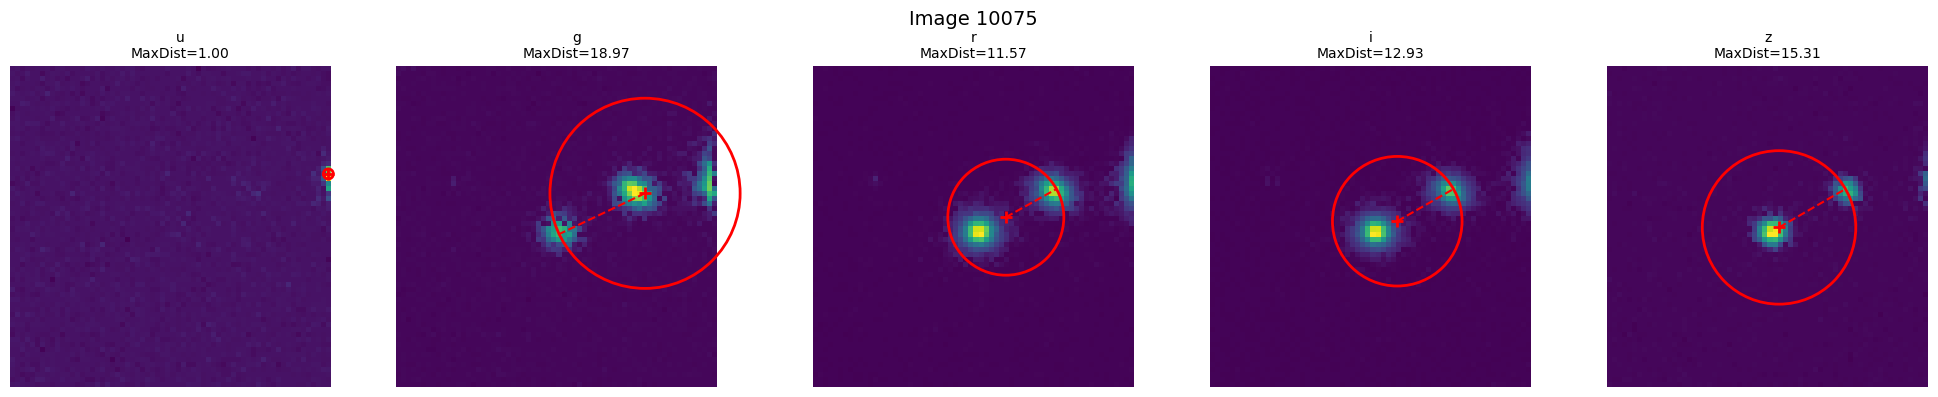

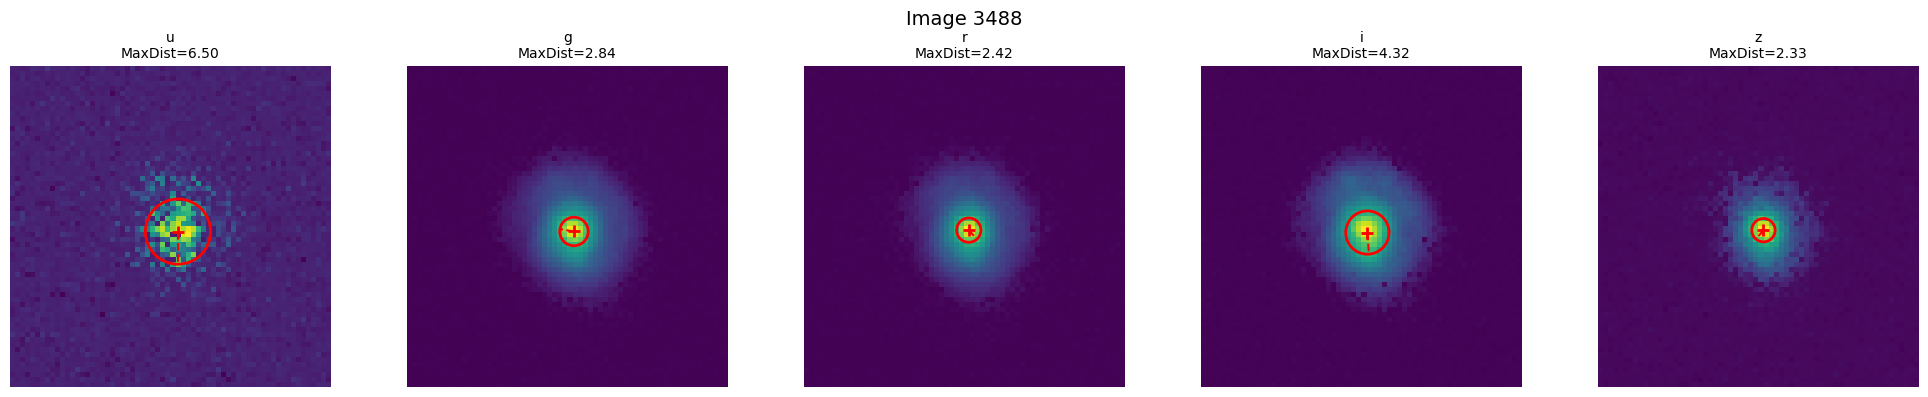

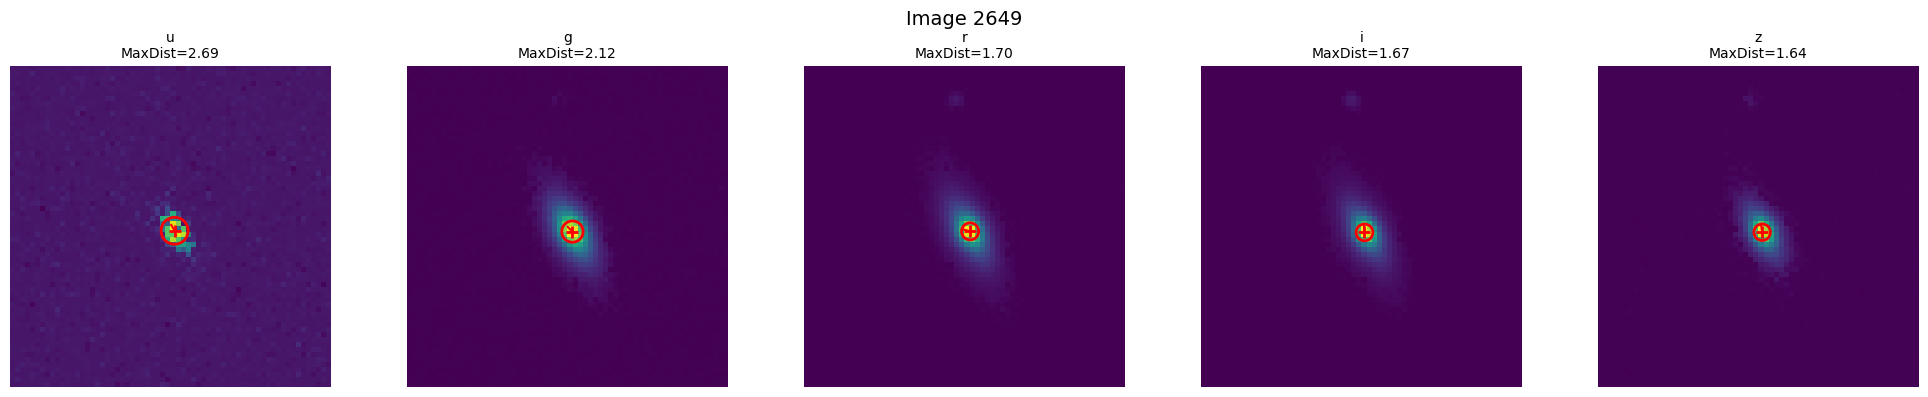

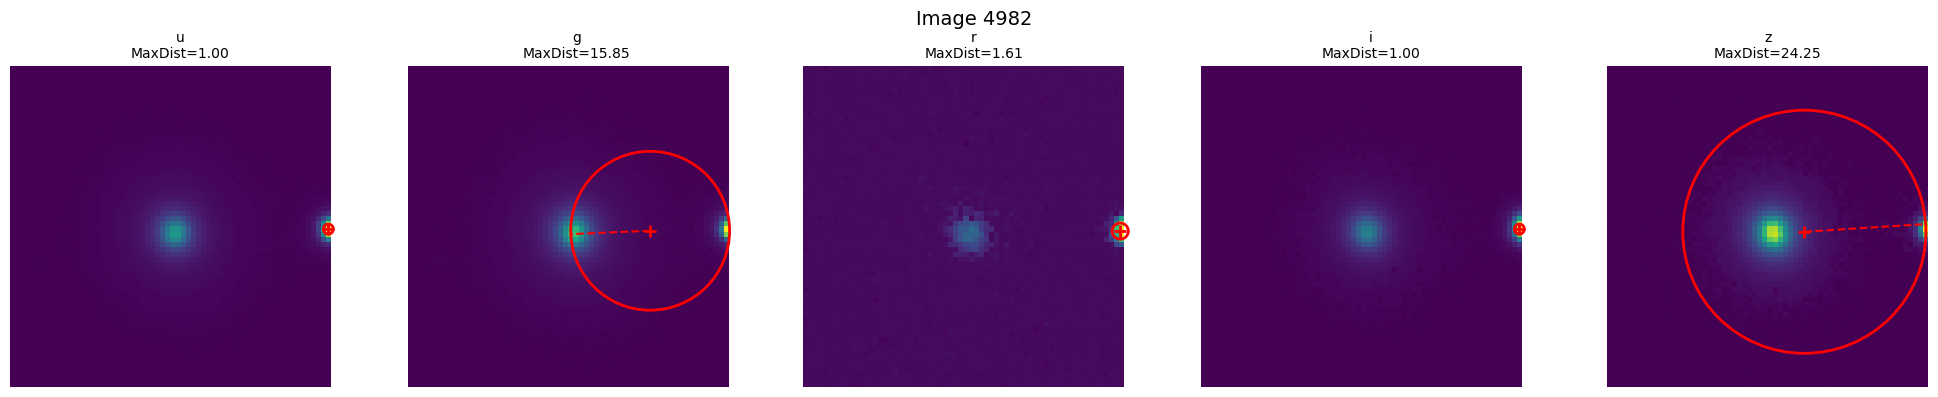

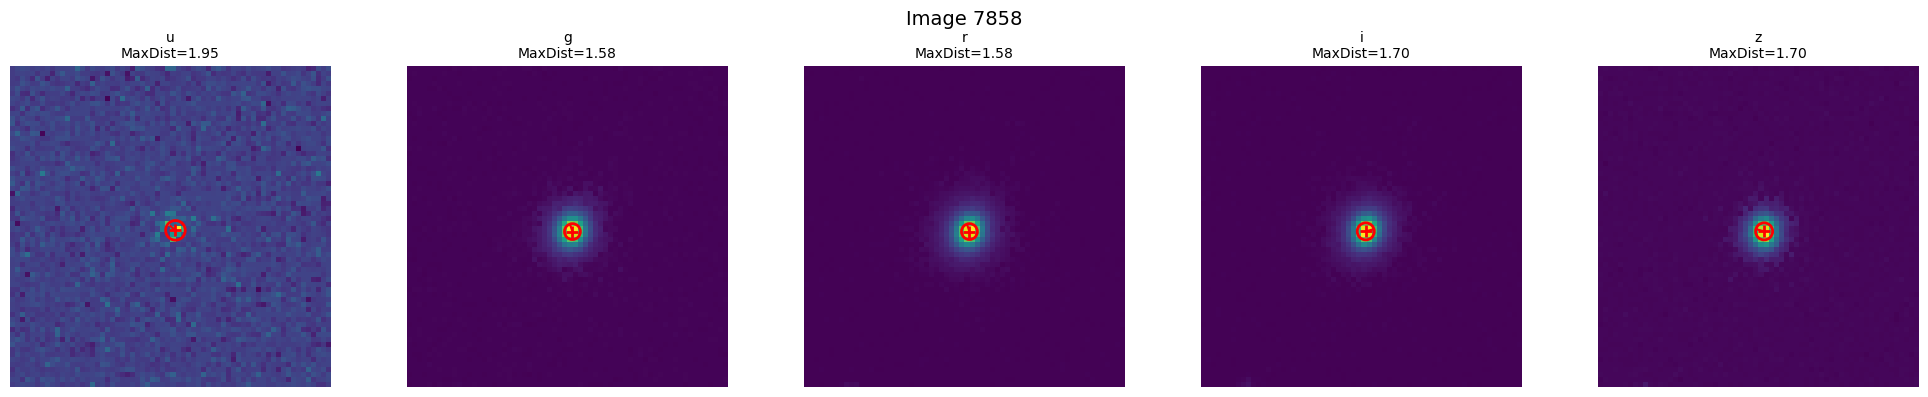

In [15]:
visualize_distance_for_filters(all_images, threshold_fraction=0.3, filters=filters, num_samples=50)